# TCAV — Tabular (UCI Adult)

Loads Adult like your snippet, preprocesses with ColumnTransformer, and runs TCAV variability plots using our framework.


In [1]:
# import shim
import sys, pathlib
for p in (pathlib.Path.cwd().parent / "src", pathlib.Path.cwd().parents[1] / "src"):
    if (p / "tcavlab").exists():
        sys.path.insert(0, str(p))
try:
    import tcavlab  # noqa: F401
    from tcavlab import ExperimentConfig, DatasetConfig, plot_variance_vs_n, plot_tcav_score_variance, precompute_cavs_for_layer
    from tcavlab.utils import device_auto, set_all_seeds, ensure_dir
    from tcavlab.cache import try_load_df_bundle, save_df_bundle
    from tcavlab.models.tabular import available_tabular_models, choose_tabular_model
    from tcavlab.activations import get_activations_from_tensor, get_gradient_at_layer
    from tcavlab.plots import plot_surround_assumption, plot_pca_projection
    from tcavlab.assumptions import check_surround_assumption
    from tcavlab.analysis_utils import (
        load_cav_vector_variance_data_cached,
        load_sensitivity_score_variance_data_cached,
        calculate_tcav_score_variance_cached,
        precompute_gradients_for_class,
    )

except ModuleNotFoundError as e:
    raise ModuleNotFoundError("Please ensure the tcavlab src/ folder is available (like in the zip I provided).") from e


In [2]:
import os, numpy as np, pandas as pd, torch
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
print("Tabular models:", available_tabular_models())
TITLE_F = 38; LABEL_F = 40; TICK_F = 30; LEGEND_TITLE_F = 34; LEGEND_F = 30
def format_float(f): return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))


Tabular models: ['mlp_small', 'mlp_medium']


In [3]:
# 1) Config
METHOD = "dom"; 
MODEL = "mlp_medium"

CONCEPT_DEFS = {"sex=Female": lambda df: df["sex"]=="Female", "sex=Male": lambda df: df["sex"]=="Male"}

cfg = ExperimentConfig(
    dataset=DatasetConfig(
        name="tabular", 
        concepts=list(CONCEPT_DEFS.keys()), 
        target_class_name=">50K", 
        target_class_index=1, 
        data_paths={}),
    method=METHOD, 
    model_key=MODEL, 
    n_values=range(10, 310, 10), 
    runs=10, 
    sets_per_run=20, 
    out_dir=f"artifacts/tabular/{MODEL}/{METHOD}", 
    seed=42,
)
set_all_seeds(cfg.seed); DEVICE = device_auto()
CACHE_DIR = os.path.join(cfg.out_dir, "cache"); 
LOAD_IF_EXISTS = False; 
os.makedirs(CACHE_DIR, exist_ok=True)
print("Device:", DEVICE)


Device: mps


In [4]:
# 2) Load Adult like your snippet
try:
    from ucimlrepo import fetch_ucirepo
    adult = fetch_ucirepo(id=2)
    X = adult.data.features; y = adult.data.targets
except Exception:
    from sklearn.datasets import fetch_openml
    adult_openml = fetch_openml('adult', version=2, as_frame=True)
    X = adult_openml.data; y = adult_openml.target.to_frame(name='income')

y = y.replace({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1}).iloc[:, 0]
categorical_features = X.select_dtypes(include=['object','category']).columns
numerical_features = X.select_dtypes(include=['int64','float64']).columns
try: ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
except TypeError: ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)
preprocessor = ColumnTransformer([('num', StandardScaler(), numerical_features), ('cat', ohe, categorical_features)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_processed = preprocessor.fit_transform(X_train); X_test_processed = preprocessor.transform(X_test)
to_dense = lambda a: a.toarray() if hasattr(a, "toarray") else a
X_train_arr = to_dense(X_train_processed).astype('float32'); X_test_arr = to_dense(X_test_processed).astype('float32')
from torch.utils.data import TensorDataset, DataLoader
X_train_tensor = torch.tensor(X_train_arr, dtype=torch.float32); y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=256, shuffle=True)
df = X_test.reset_index(drop=True).copy(); df['income'] = y_test.values; df = df[['age','education','race','sex','income']]
print(df.head(3))


   age     education   race     sex  income
0   30       HS-grad  White    Male       0
1   54    Assoc-acdm  White    Male       0
2   21  Some-college  White  Female       0


/var/folders/k7/xf0yhfbs02ggfm7n1l5g_cnm0000gn/T/ipykernel_6540/1268281699.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1}).iloc[:, 0]


In [5]:
# 3) Model + quick training
NUM_FEATURES = X_train_arr.shape[1]; NUM_CLASSES = 2
model, layer_names, DEVICE, hidden = choose_tabular_model(cfg.model_key, num_features=NUM_FEATURES, num_classes=NUM_CLASSES, device=DEVICE)
print("Layers:", layer_names)
EPOCHS = 10
if EPOCHS>0:
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_fn = torch.nn.CrossEntropyLoss()
    model.train()
    for ep in range(1, EPOCHS+1):
        tot = n = 0; corr = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(xb); loss = loss_fn(logits, yb); loss.backward(); opt.step()
            tot += float(loss.item()) * len(xb); n += len(xb); corr += int((logits.argmax(1)==yb).sum())
        print(f"epoch {ep:02d} loss={tot/n:.4f} acc={corr/n:.3f}")
    model.eval()


Layers: ['fc_in', 'hidden_layers.0', 'hidden_layers.2']
epoch 01 loss=0.3699 acc=0.828
epoch 02 loss=0.3089 acc=0.857
epoch 03 loss=0.3048 acc=0.858
epoch 04 loss=0.3019 acc=0.859
epoch 05 loss=0.2992 acc=0.860
epoch 06 loss=0.2967 acc=0.860
epoch 07 loss=0.2944 acc=0.863
epoch 08 loss=0.2913 acc=0.863
epoch 09 loss=0.2891 acc=0.865
epoch 10 loss=0.2861 acc=0.866


In [6]:
# 4) Concepts, random, target-class
concept_arrays = {}
for cname, fn in CONCEPT_DEFS.items():
    m = fn(df); concept_arrays[cname] = X_test_arr[m.values]
    print(cname, concept_arrays[cname].shape)
Xrand = X_train_arr
Xclass = X_test_arr[df['income'].values==1]
print("Random:", Xrand.shape, "| Target-class:", Xclass.shape)


sex=Female (3289, 111)
sex=Male (6480, 111)
Random: (39073, 111) | Target-class: (2338, 111)


In [7]:
# 5) Helpers for activations/gradients
from tcavlab.activations import get_activations_from_tensor, get_gradient_at_layer
def activations_from_array(X, layer_name, bs=512):
    outs=[]; 
    for i in range(0, len(X), bs):
        xb = torch.from_numpy(X[i:i+bs]).to(DEVICE)
        A = get_activations_from_tensor(model, xb, layer_name, DEVICE)
        outs.append(A.numpy())
    import numpy as np
    return np.vstack(outs) if outs else np.zeros((0,0),dtype="float32")

def single_gradient_vector(layer_name, class_index):
    if len(Xclass)==0: return None
    xb = torch.from_numpy(Xclass[:1]).to(DEVICE)
    g = get_gradient_at_layer(model, xb, layer_name, class_index, DEVICE)
    return None if g is None else g[0]


In [8]:
# 6) Precompute CAVs
for layer in layer_names:
    for concept in cfg.dataset.concepts:
        print(f"Layer: {layer} — Concept: {concept}")
        pos_acts = activations_from_array(concept_arrays[concept], layer)
        neg_acts = activations_from_array(Xrand, layer)
        base_dir = os.path.join(cfg.out_dir, layer, concept); ensure_dir(base_dir)
        precompute_cavs_for_layer(
            X_pos=pos_acts, X_neg=neg_acts, layer_name=layer, method=cfg.method,
            n_values=cfg.n_values, runs=cfg.runs, sets_per_run=cfg.sets_per_run,
            out_dir=base_dir, seed=cfg.seed,
        )
print("CAV precomputation done.")


Layer: fc_in — Concept: sex=Female
CAV file already exists, skipping: artifacts/tabular/mlp_medium/dom/fc_in/sex=Female/10/run_0.pkl
CAV file already exists, skipping: artifacts/tabular/mlp_medium/dom/fc_in/sex=Female/10/run_1.pkl
CAV file already exists, skipping: artifacts/tabular/mlp_medium/dom/fc_in/sex=Female/10/run_2.pkl
CAV file already exists, skipping: artifacts/tabular/mlp_medium/dom/fc_in/sex=Female/10/run_3.pkl
CAV file already exists, skipping: artifacts/tabular/mlp_medium/dom/fc_in/sex=Female/10/run_4.pkl
CAV file already exists, skipping: artifacts/tabular/mlp_medium/dom/fc_in/sex=Female/10/run_5.pkl
CAV file already exists, skipping: artifacts/tabular/mlp_medium/dom/fc_in/sex=Female/10/run_6.pkl
CAV file already exists, skipping: artifacts/tabular/mlp_medium/dom/fc_in/sex=Female/10/run_7.pkl
CAV file already exists, skipping: artifacts/tabular/mlp_medium/dom/fc_in/sex=Female/10/run_8.pkl
CAV file already exists, skipping: artifacts/tabular/mlp_medium/dom/fc_in/sex=Femal

Fit: $ 7.31/N \; + \; 0.115 $
Plot saved to artifacts/tabular/mlp_medium/dom/plots/cav_vector_variance_mlp_medium_fc_in_dom.pdf


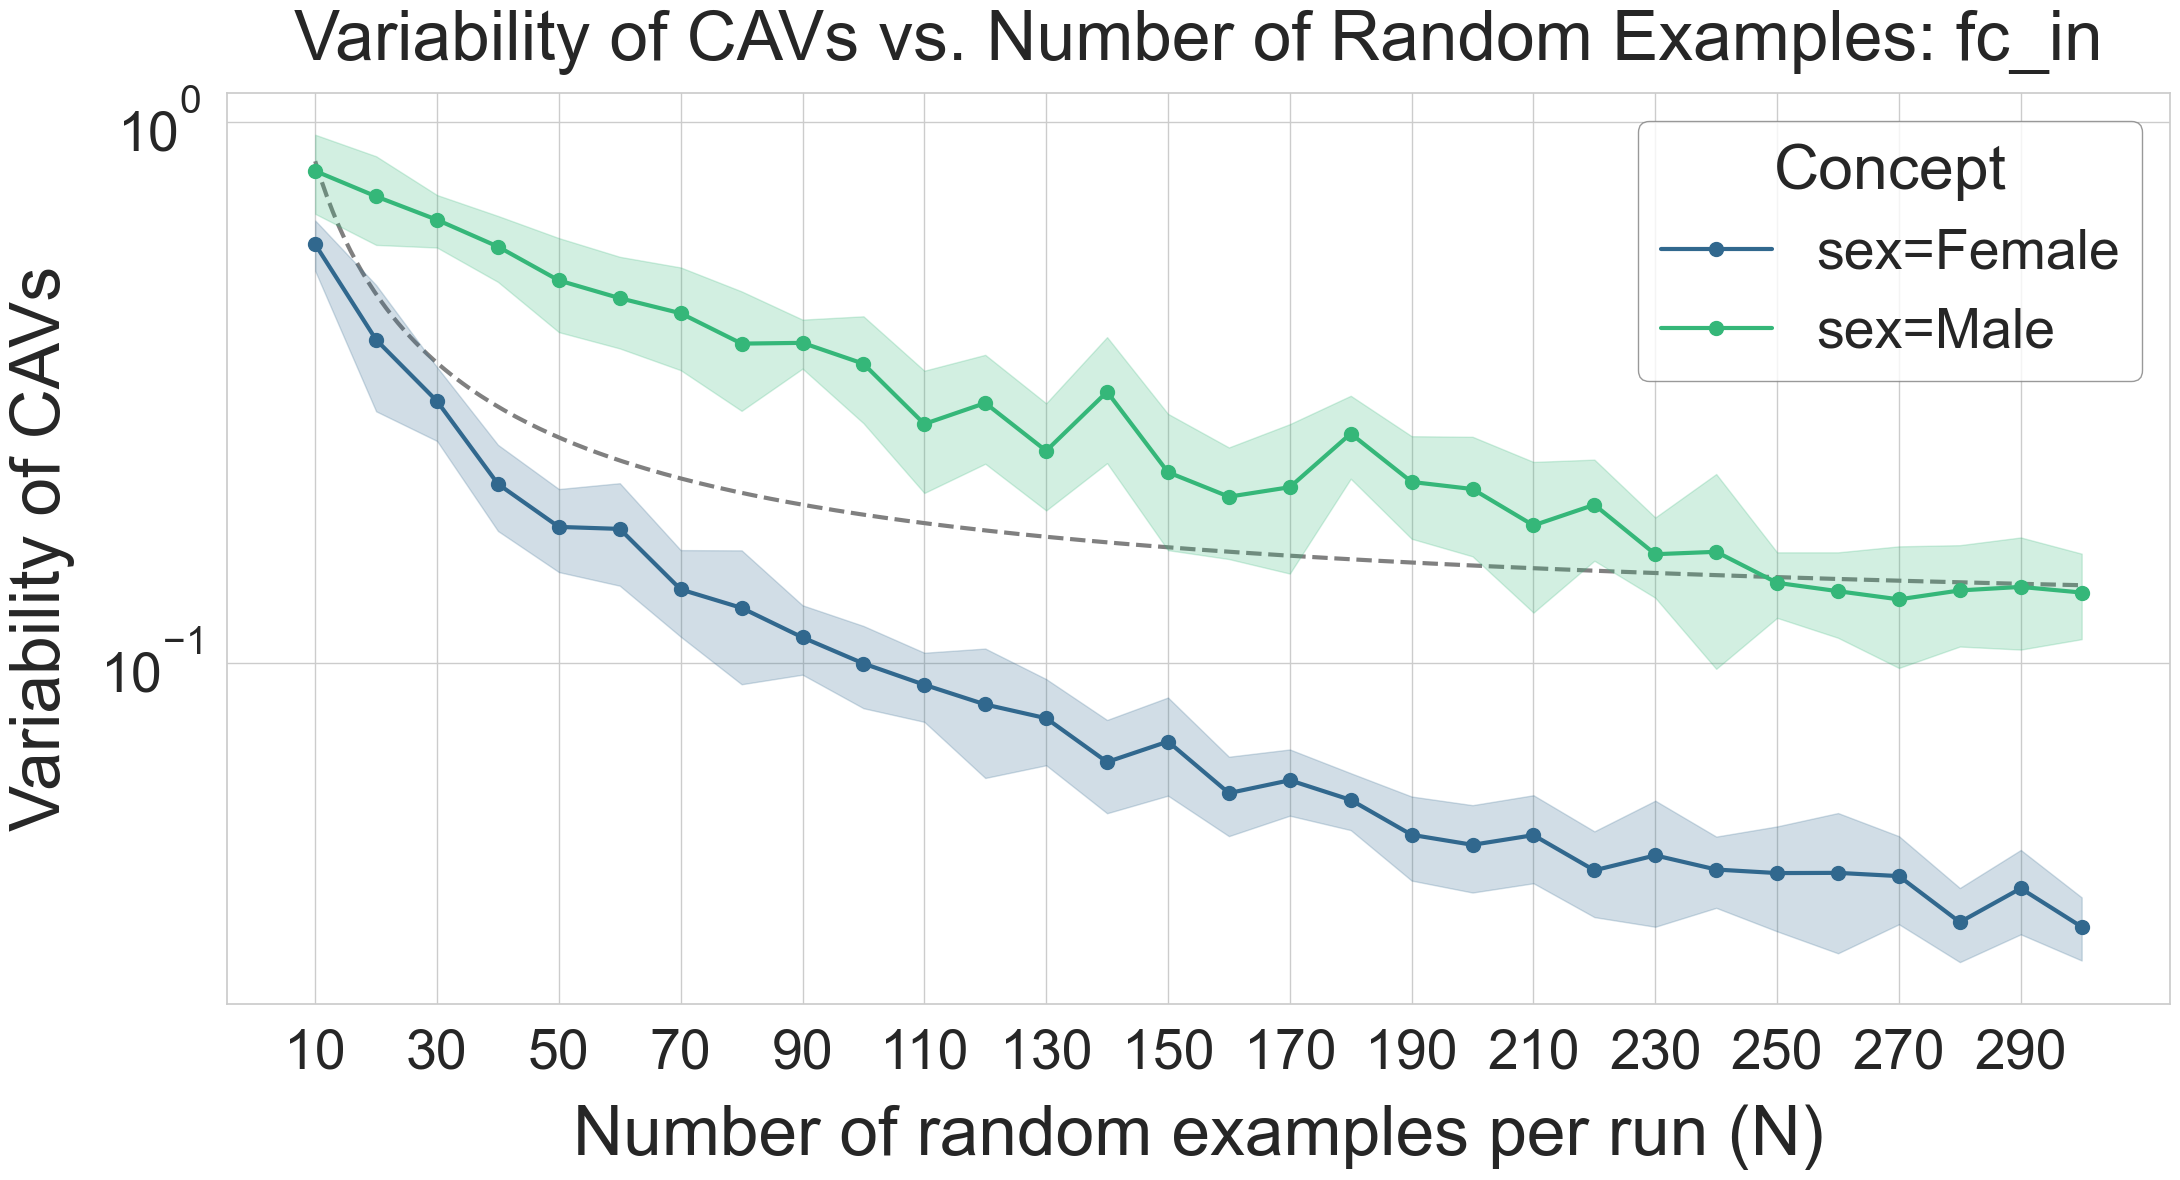

Fit: $ 7.24/N \; + \; 0.0317 $
Plot saved to artifacts/tabular/mlp_medium/dom/plots/cav_vector_variance_mlp_medium_hidden_layers.0_dom.pdf


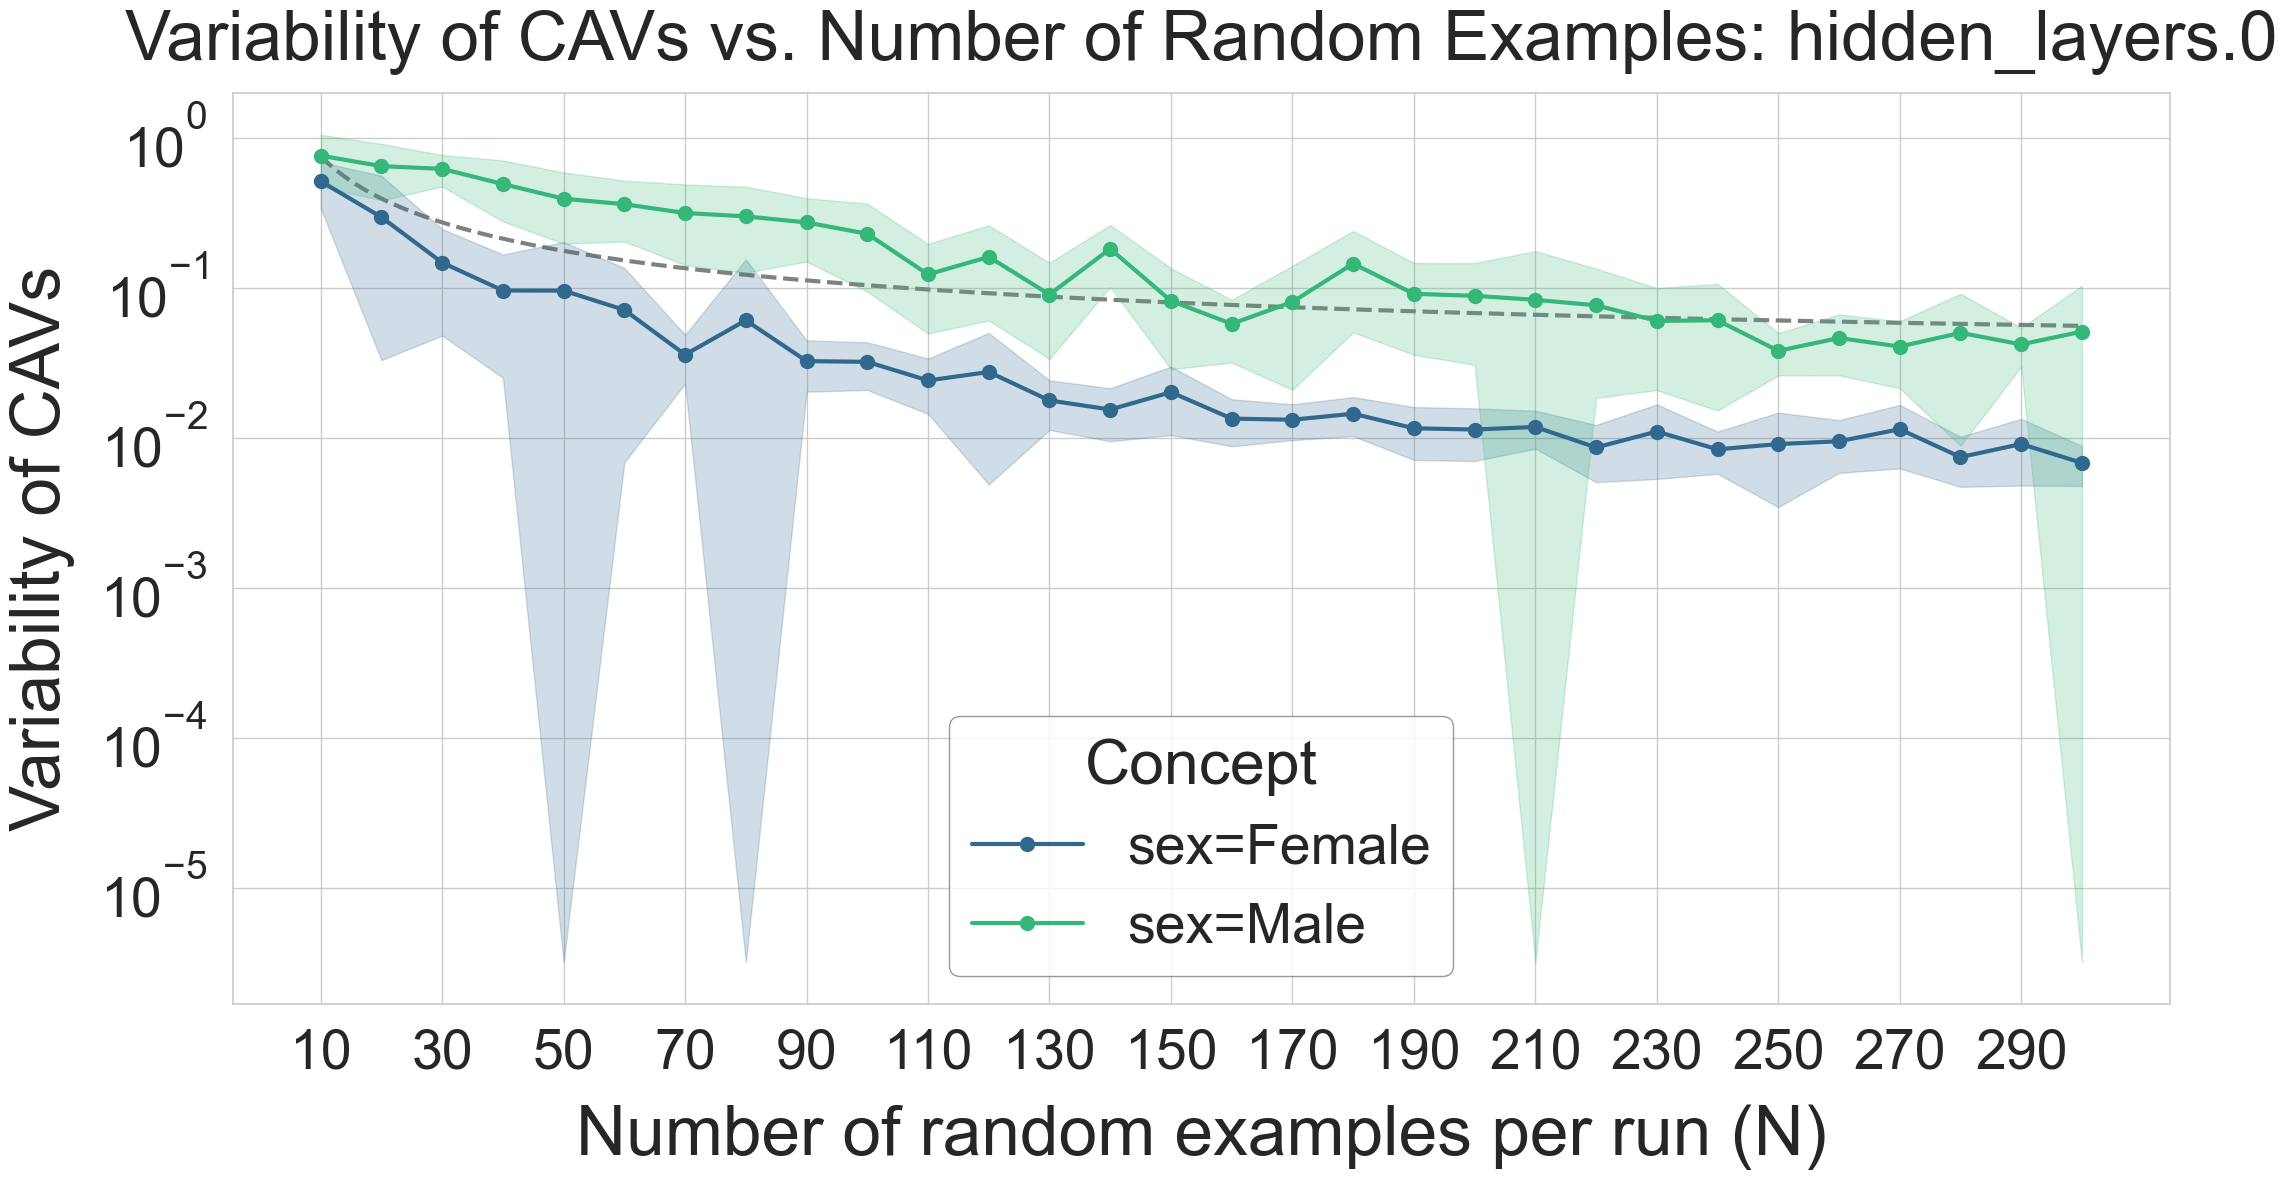

Fit: $ 7.32/N \; + \; 0.00606 $
Plot saved to artifacts/tabular/mlp_medium/dom/plots/cav_vector_variance_mlp_medium_hidden_layers.2_dom.pdf


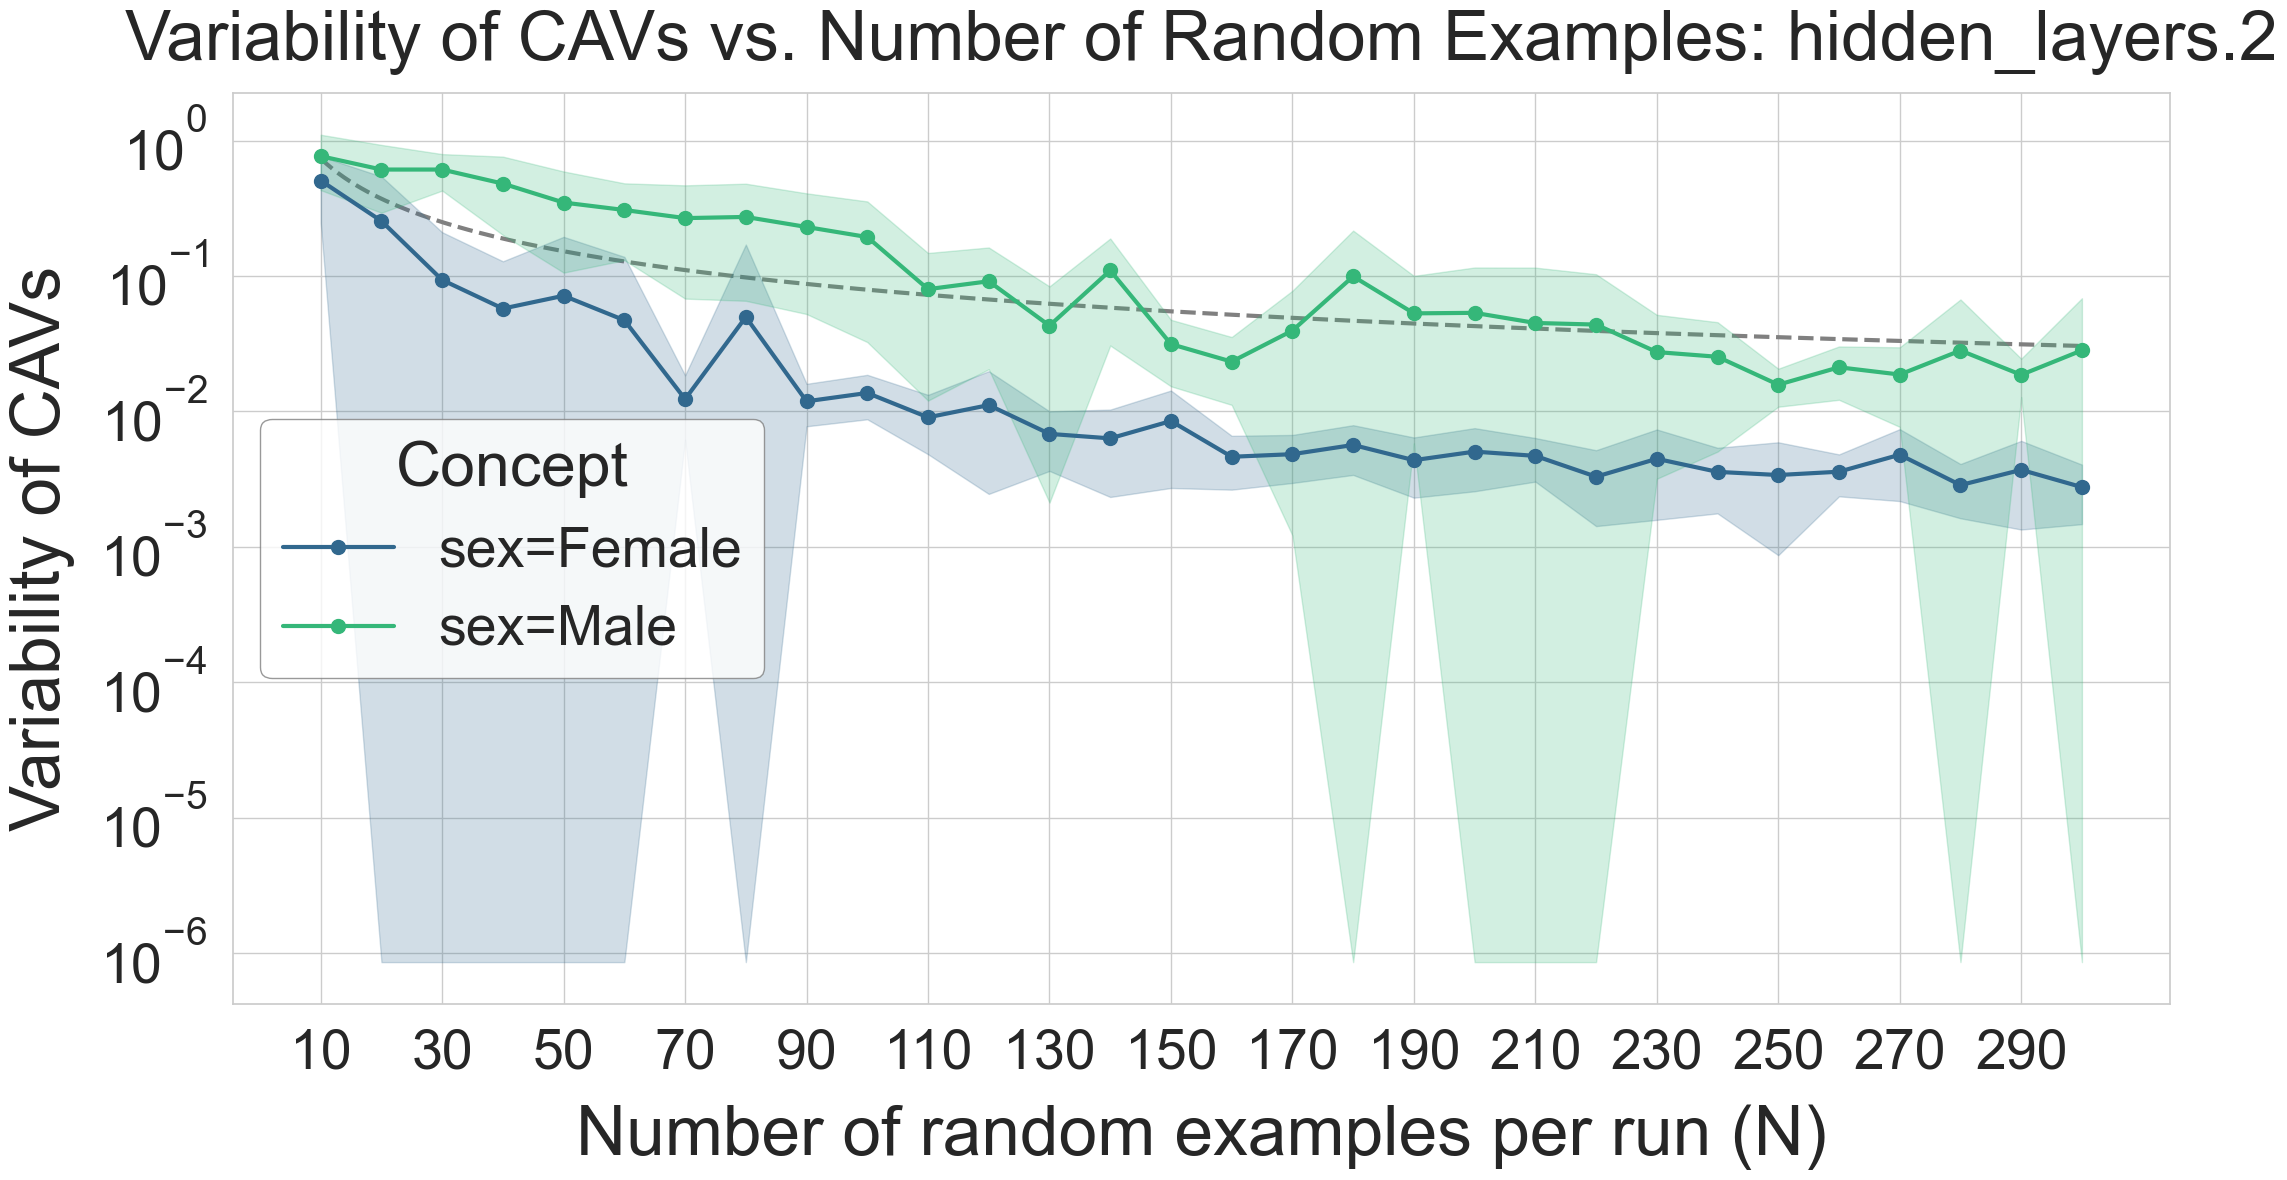

In [9]:
# 7) CAV vector variability
for layer in layer_names:
    df_var = load_cav_vector_variance_data_cached(
        layer=layer, cav_output_dir=cfg.out_dir, concepts_to_load=cfg.dataset.concepts,
        n_values=list(cfg.n_values), runs=int(cfg.runs),
        cache_dir=CACHE_DIR, cache_key=f"trace_variance__{cfg.dataset.name}_{cfg.method}_{layer}",
        load_if_exists=LOAD_IF_EXISTS, save=True,
    )
    plot_variance_vs_n(
        df=df_var, layer=layer, title=f"Variability of CAVs vs. Number of Random Examples: {layer}",
        ylabel="Variability of CAVs",
        save_path=os.path.join(cfg.out_dir, "plots", f"cav_vector_variance_{MODEL}_{layer}_{METHOD}.pdf"),
        fit_thresholds=[0], cache_dir=CACHE_DIR, cache_key=f"trace_variance_plot__{cfg.dataset.name}_{cfg.method}_{layer}",
        load_if_exists=LOAD_IF_EXISTS, save_bundle=True,
    )


Fit: $ 2.08/N \; + \; 0.034 $
Plot saved to artifacts/tabular/mlp_medium/dom/plots/sensitivity_variance_mlp_medium_fc_in_dom.pdf


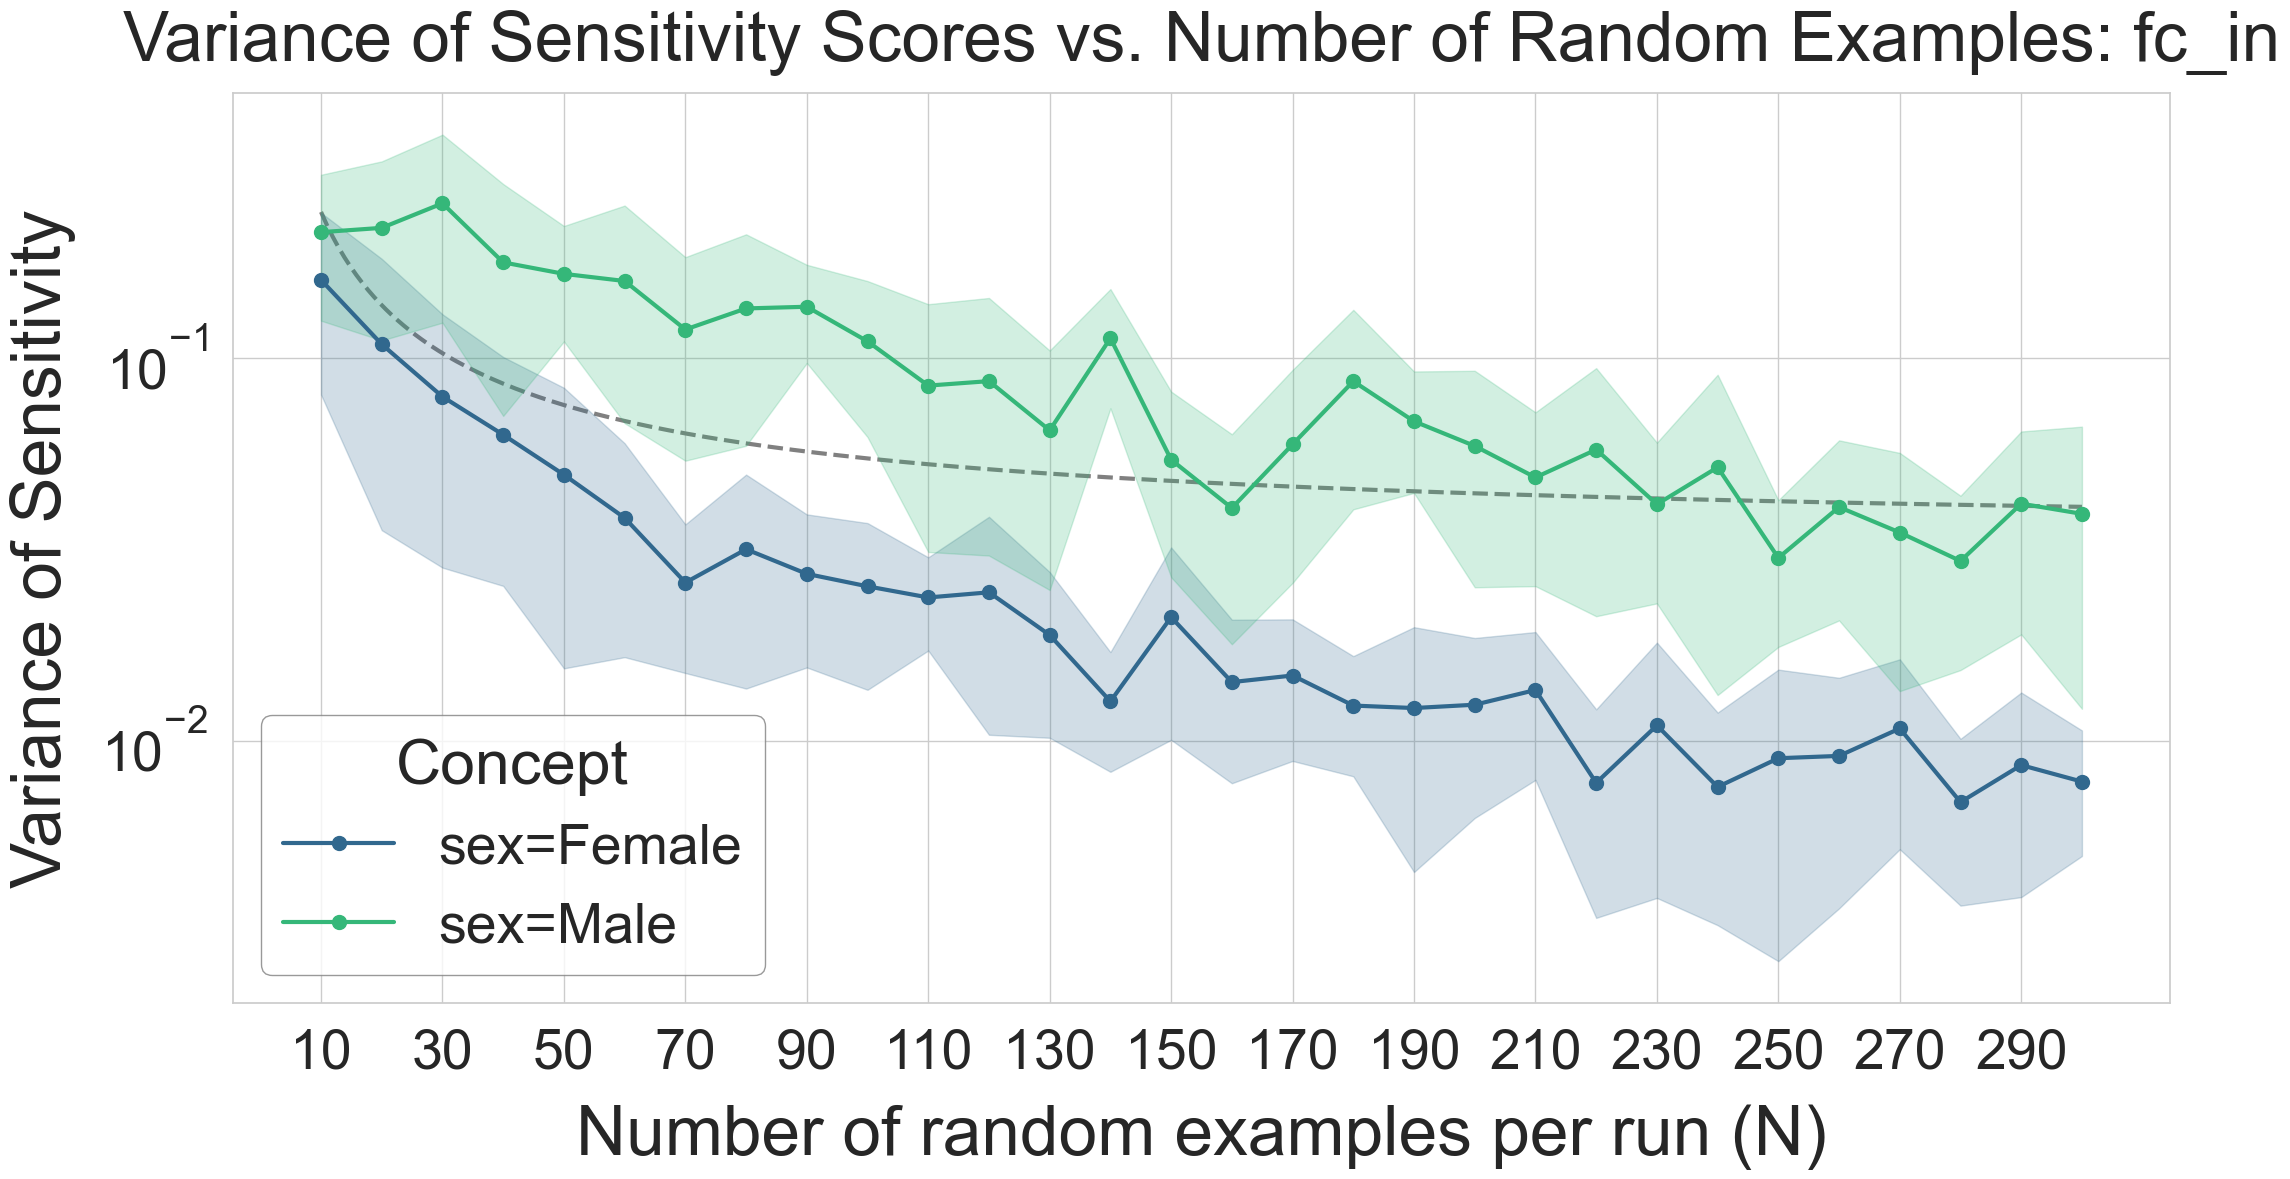

Fit: $ 7.19/N \; + \; 0.00189 $
Plot saved to artifacts/tabular/mlp_medium/dom/plots/sensitivity_variance_mlp_medium_hidden_layers.0_dom.pdf


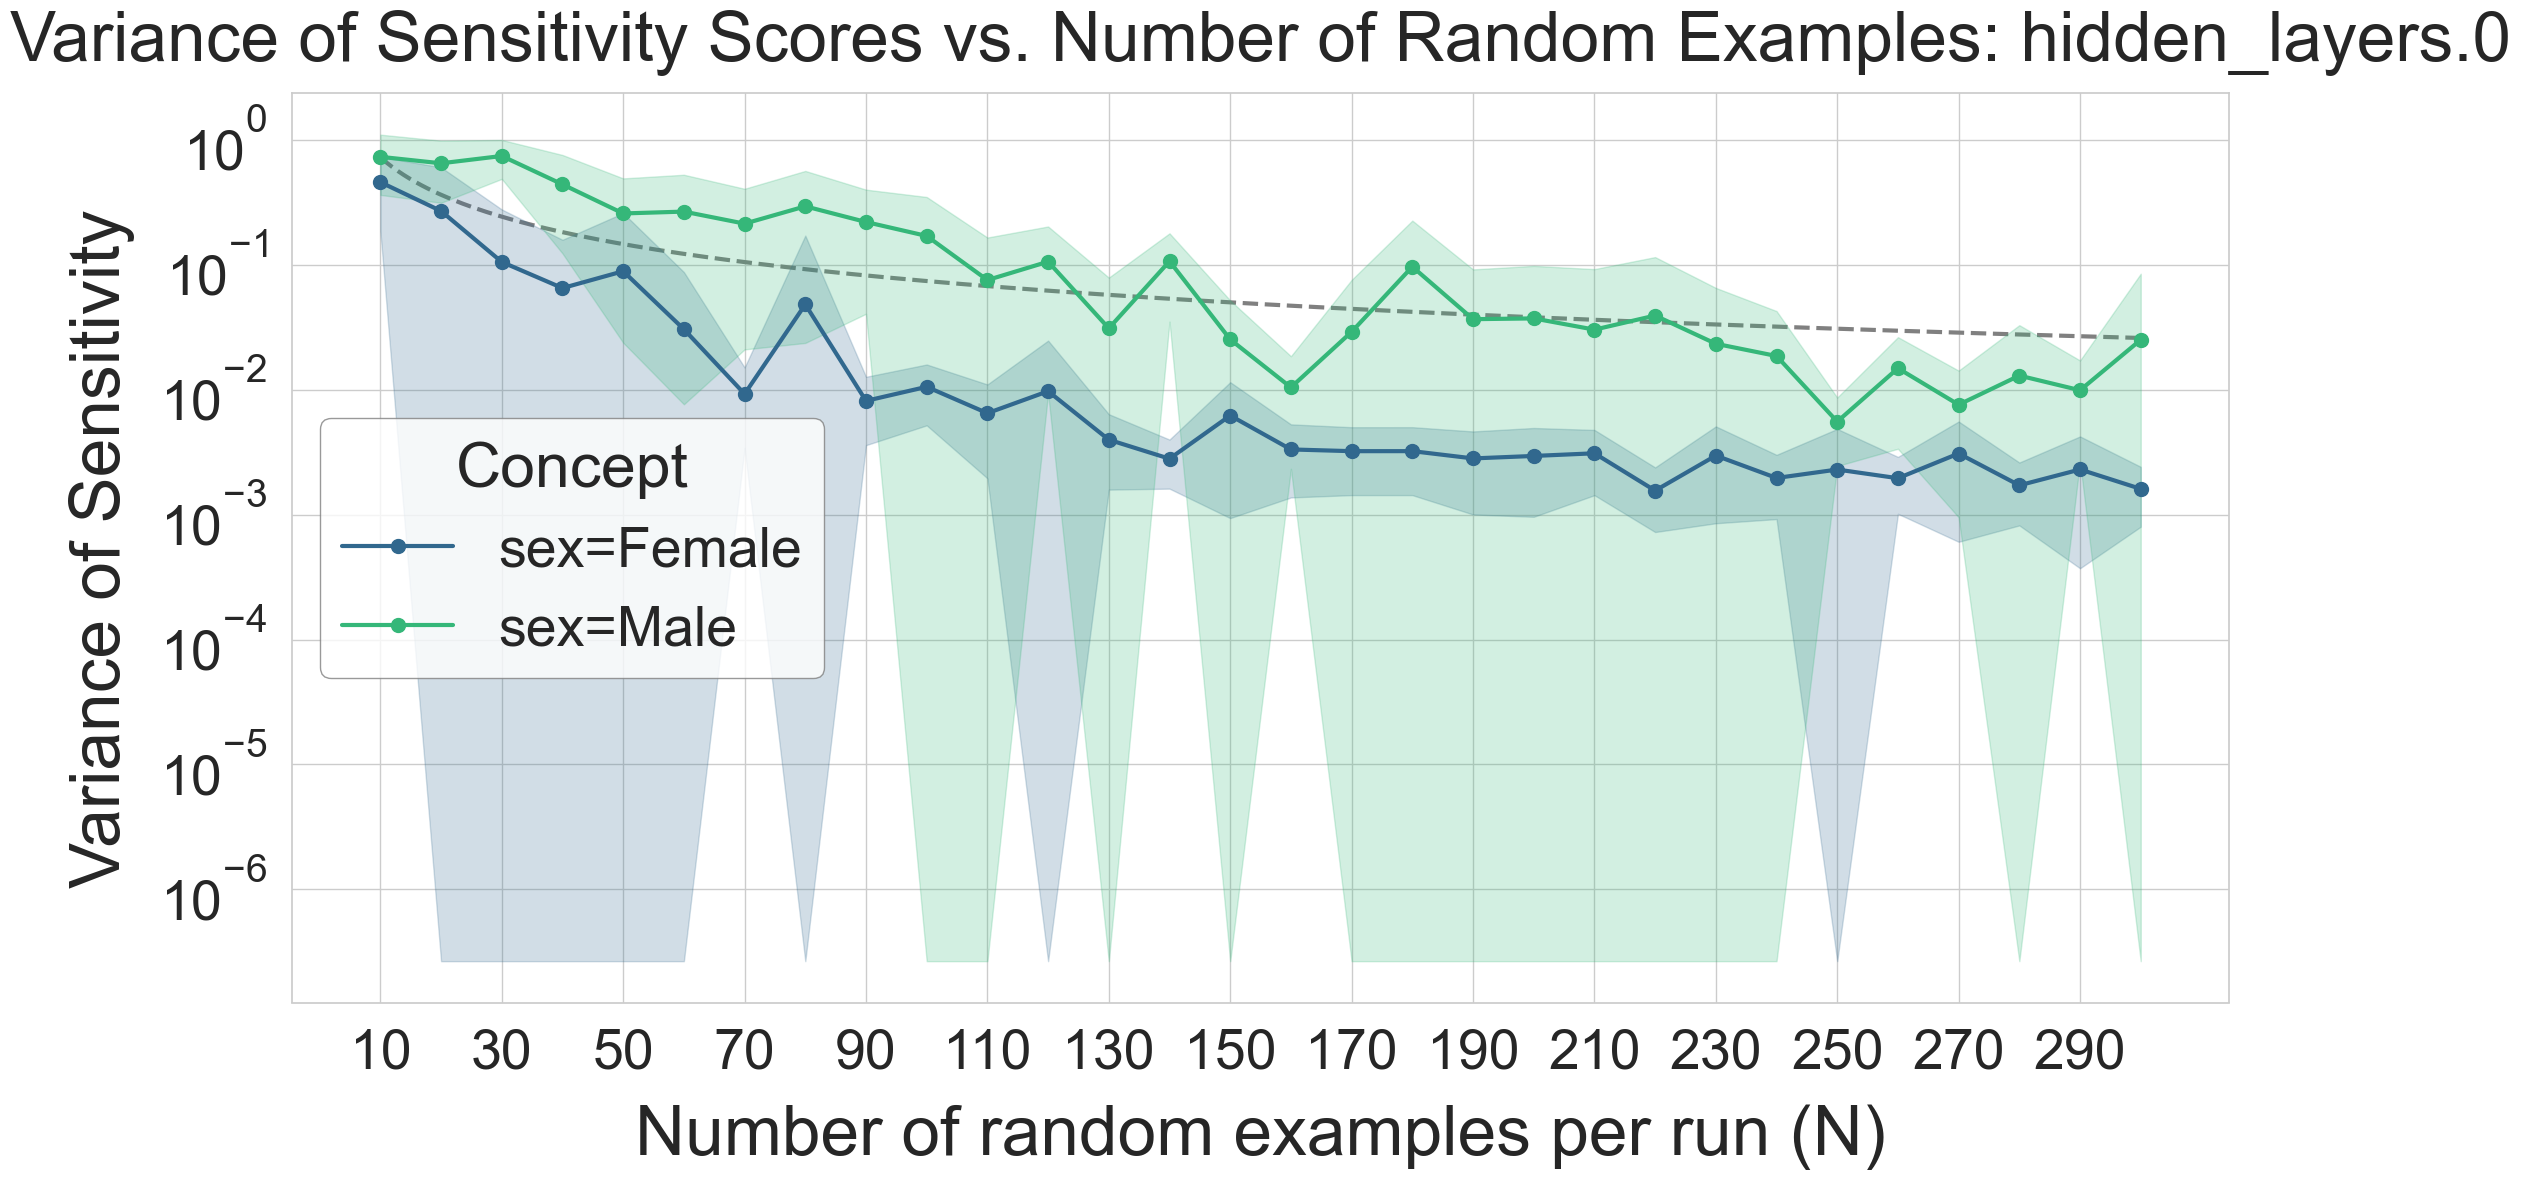

Fit: $ 2.47/N \; + \; 9.03\times 10^{-11} $
Plot saved to artifacts/tabular/mlp_medium/dom/plots/sensitivity_variance_mlp_medium_hidden_layers.2_dom.pdf


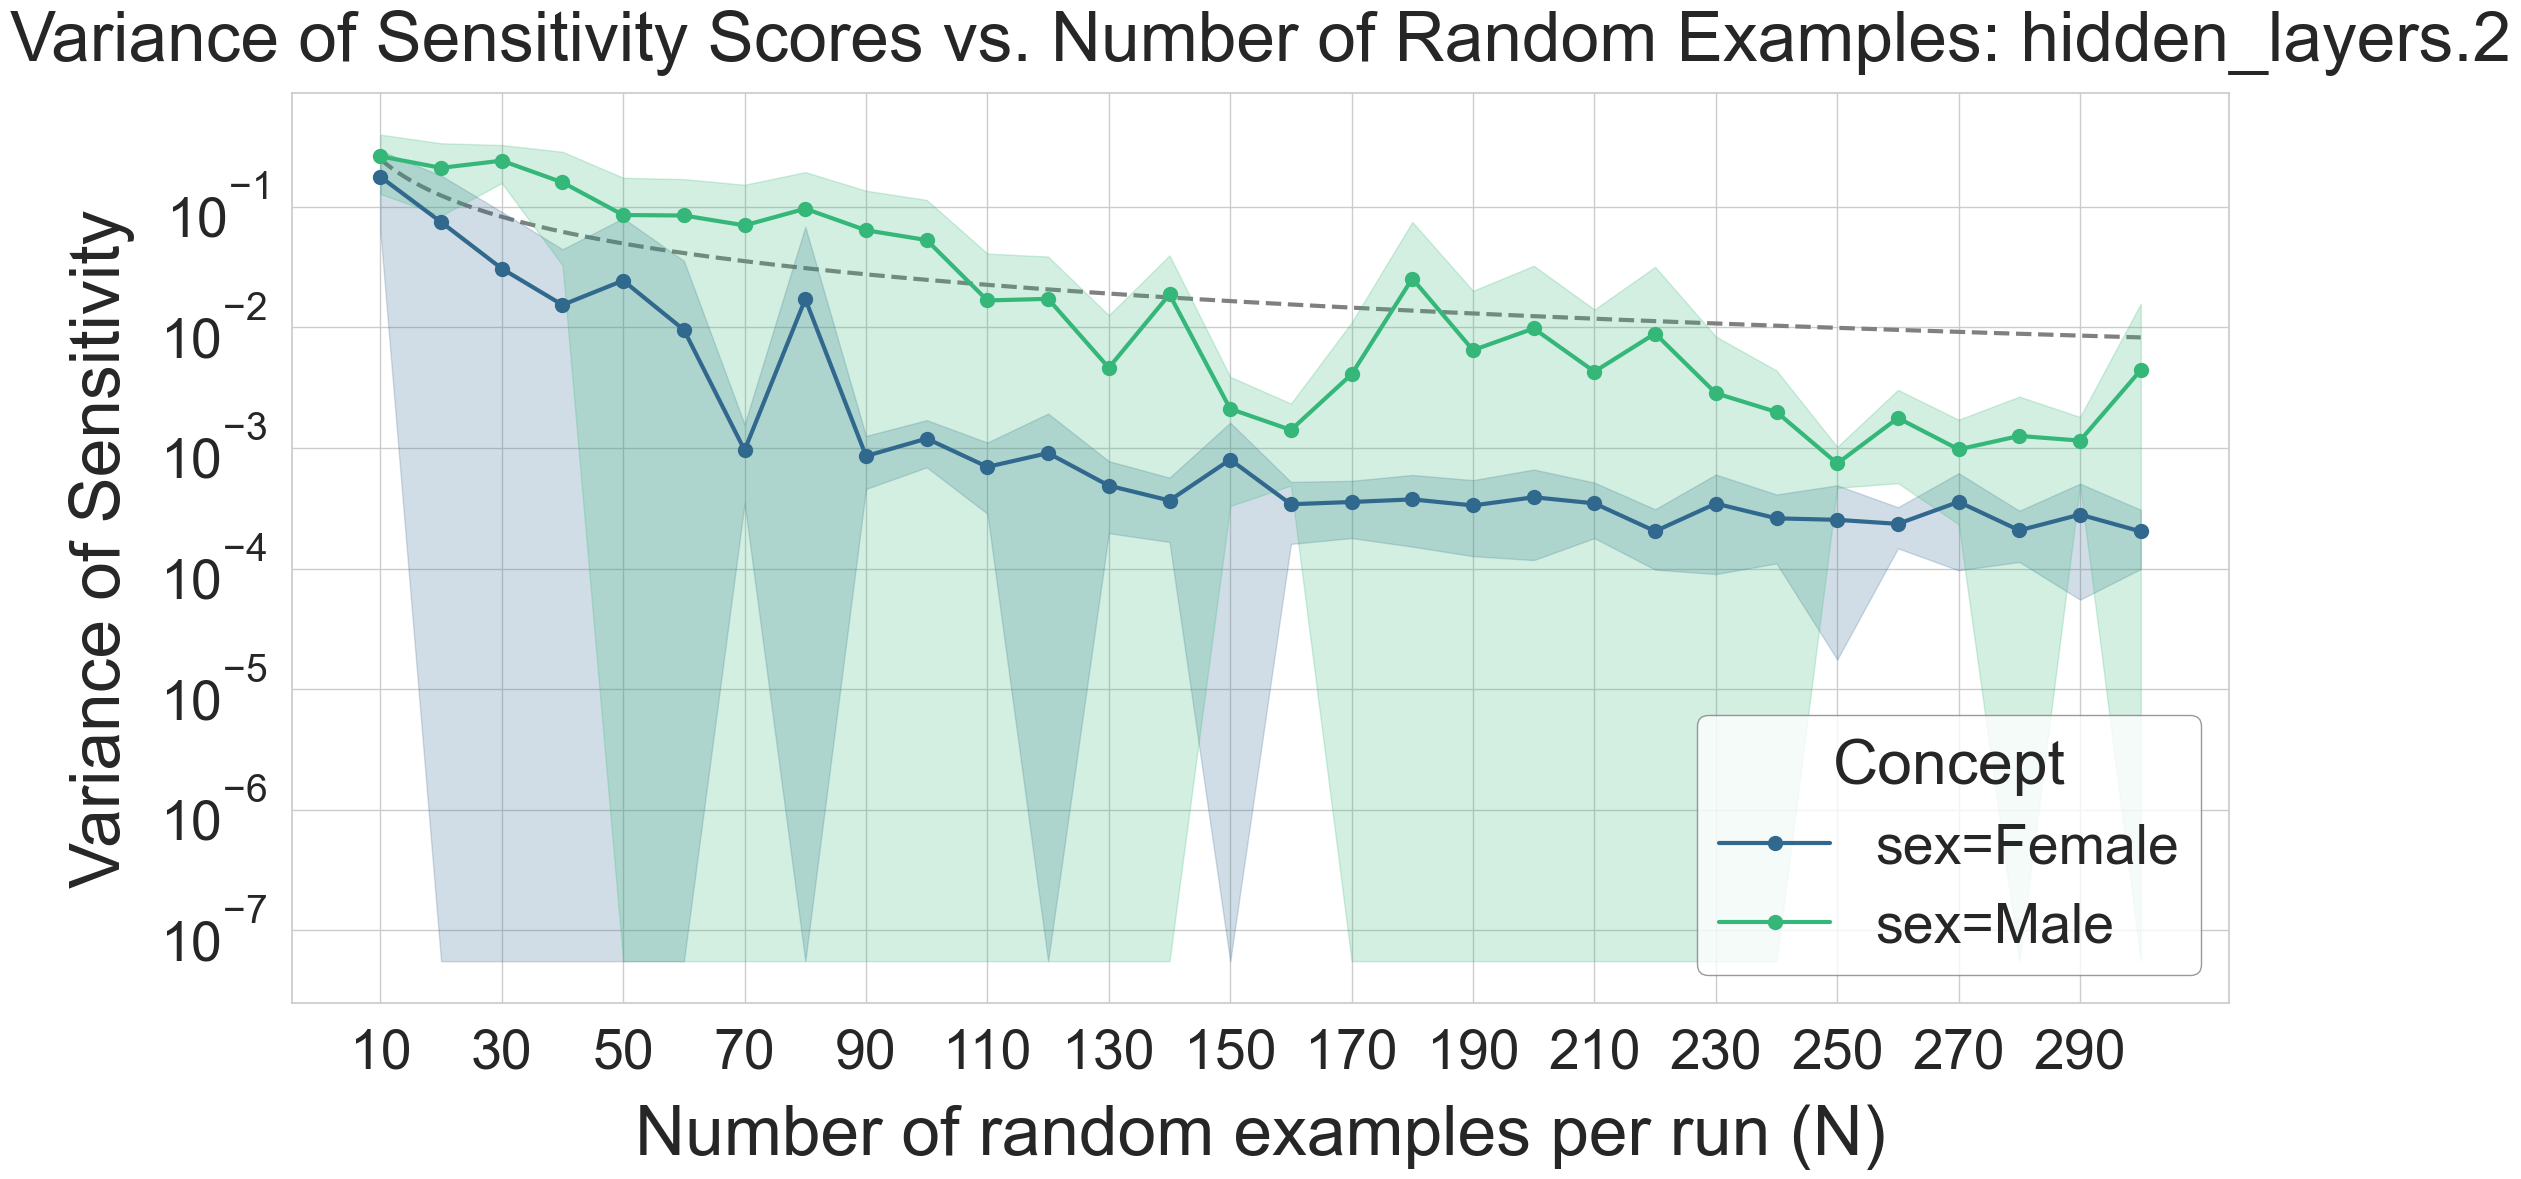

In [10]:
# 8) Sensitivity score variance
for layer in layer_names:
    g = single_gradient_vector(layer, cfg.dataset.target_class_index)
    if g is None: print("Skip sensitivity (no gradient) for", layer); continue
    df_sens = load_sensitivity_score_variance_data_cached(
        layer=layer, gradient_vector=g, cav_output_dir=cfg.out_dir,
        concepts_to_load=cfg.dataset.concepts, n_values=list(cfg.n_values), runs=int(cfg.runs),
        cache_dir=CACHE_DIR, cache_key=f"sens_score_var__{cfg.dataset.name}_{cfg.method}_{layer}",
        load_if_exists=LOAD_IF_EXISTS, save=True,
    )
    plot_variance_vs_n(
        df=df_sens, layer=layer,
        title=f"Variance of Sensitivity Scores vs. Number of Random Examples: {layer}",
        ylabel="Variance of Sensitivity",
        save_path=os.path.join(cfg.out_dir, "plots", f"sensitivity_variance_{MODEL}_{layer}_{METHOD}.pdf"),
        fit_thresholds=[0], cache_dir=CACHE_DIR, cache_key=f"sens_var_plot__{cfg.dataset.name}_{cfg.method}_{layer}",
        load_if_exists=LOAD_IF_EXISTS, save_bundle=True,
    )


Fit: $ 1.06/N \; + \; 0.0209 $
Plot saved to artifacts/tabular/mlp_medium/dom/plots/tcav_score_variance_mlp_medium_fc_in_dom.pdf


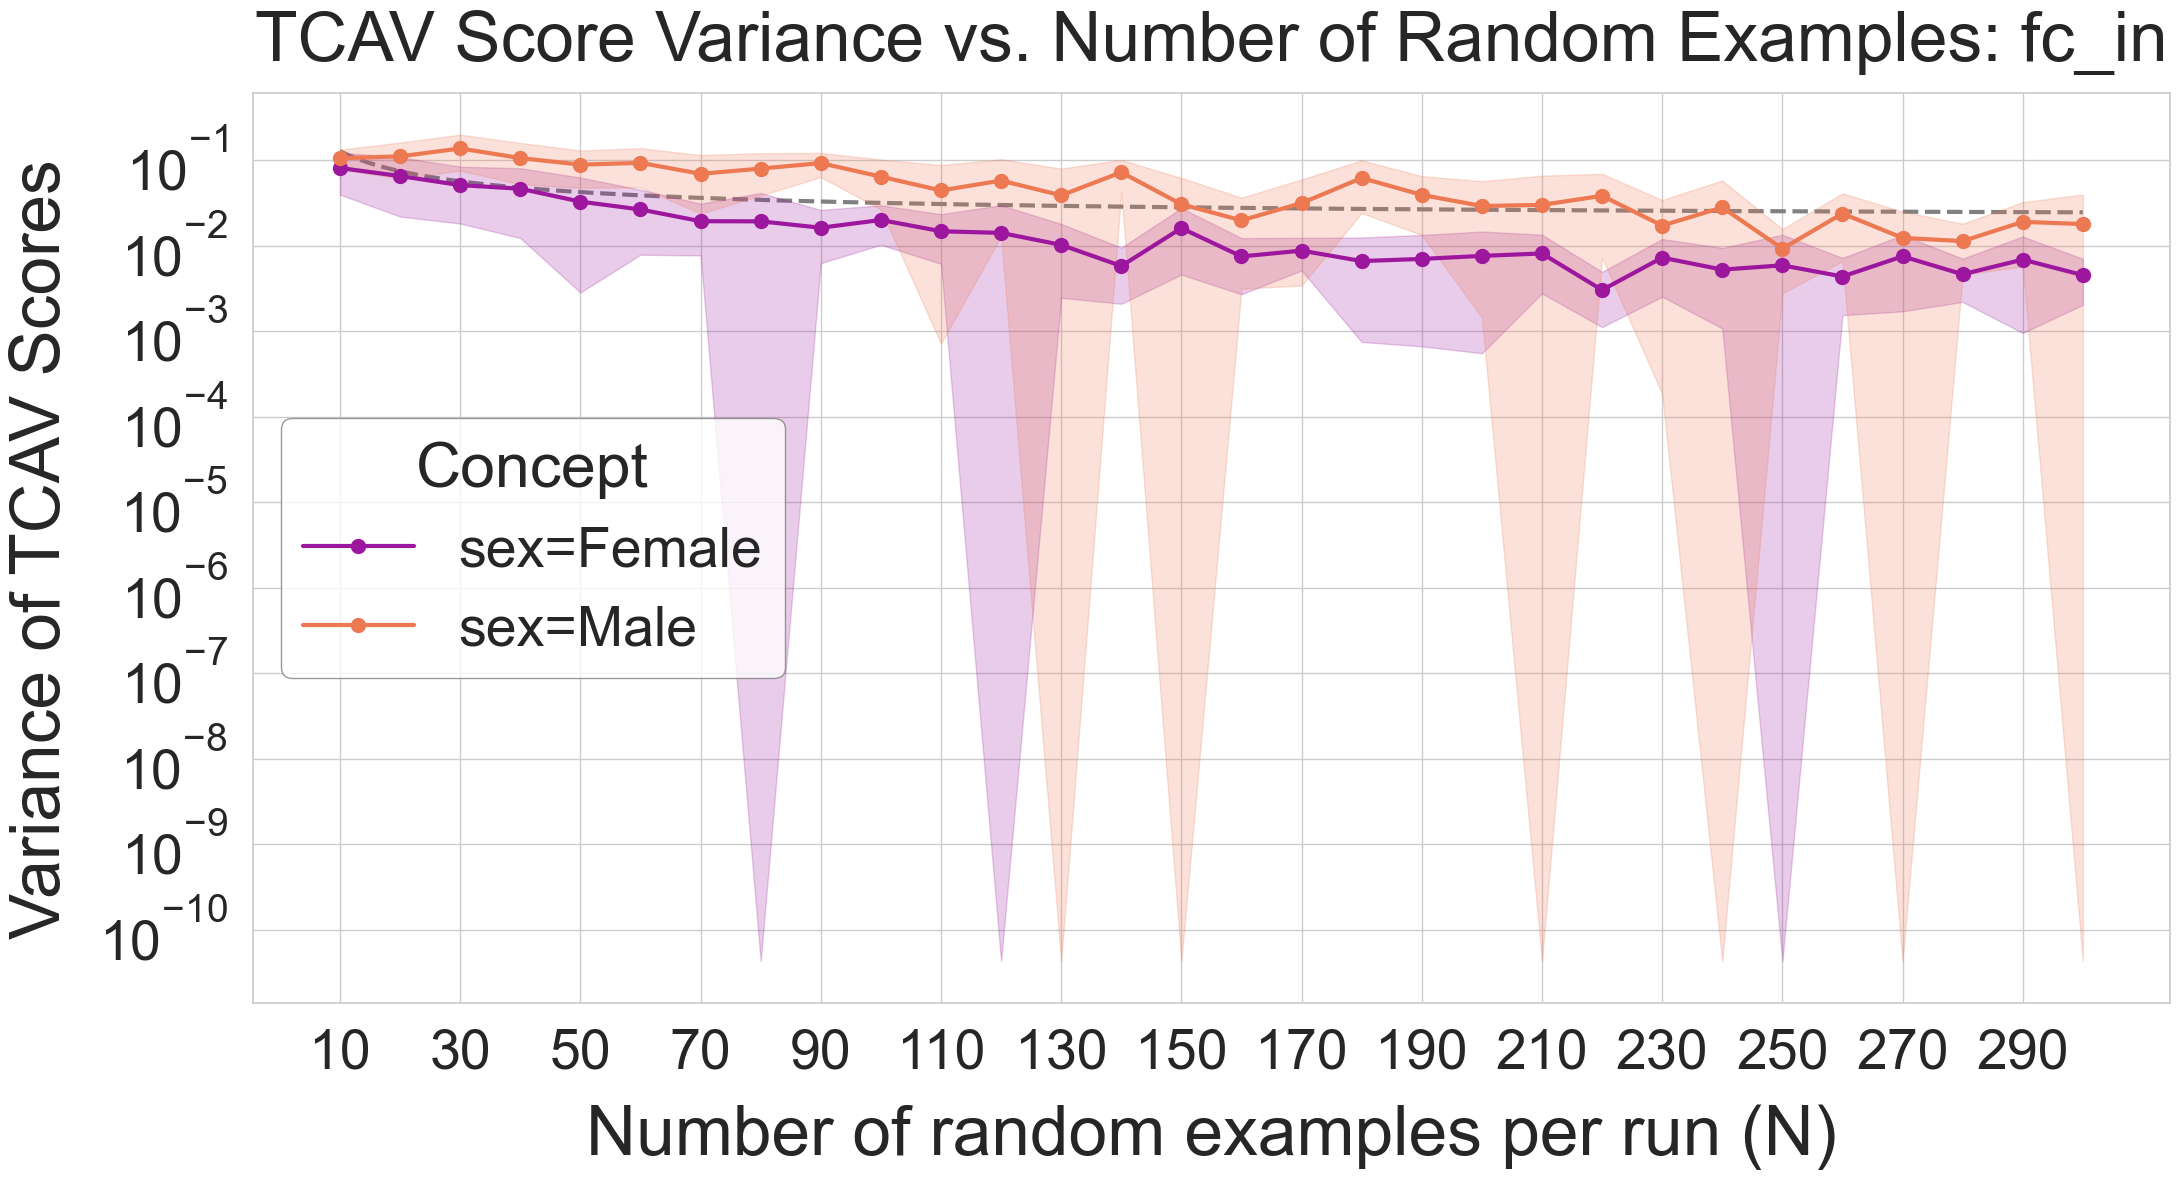

Fit: $ 1.81/N \; + \; 3.05\times 10^{-4} $
Plot saved to artifacts/tabular/mlp_medium/dom/plots/tcav_score_variance_mlp_medium_hidden_layers.0_dom.pdf


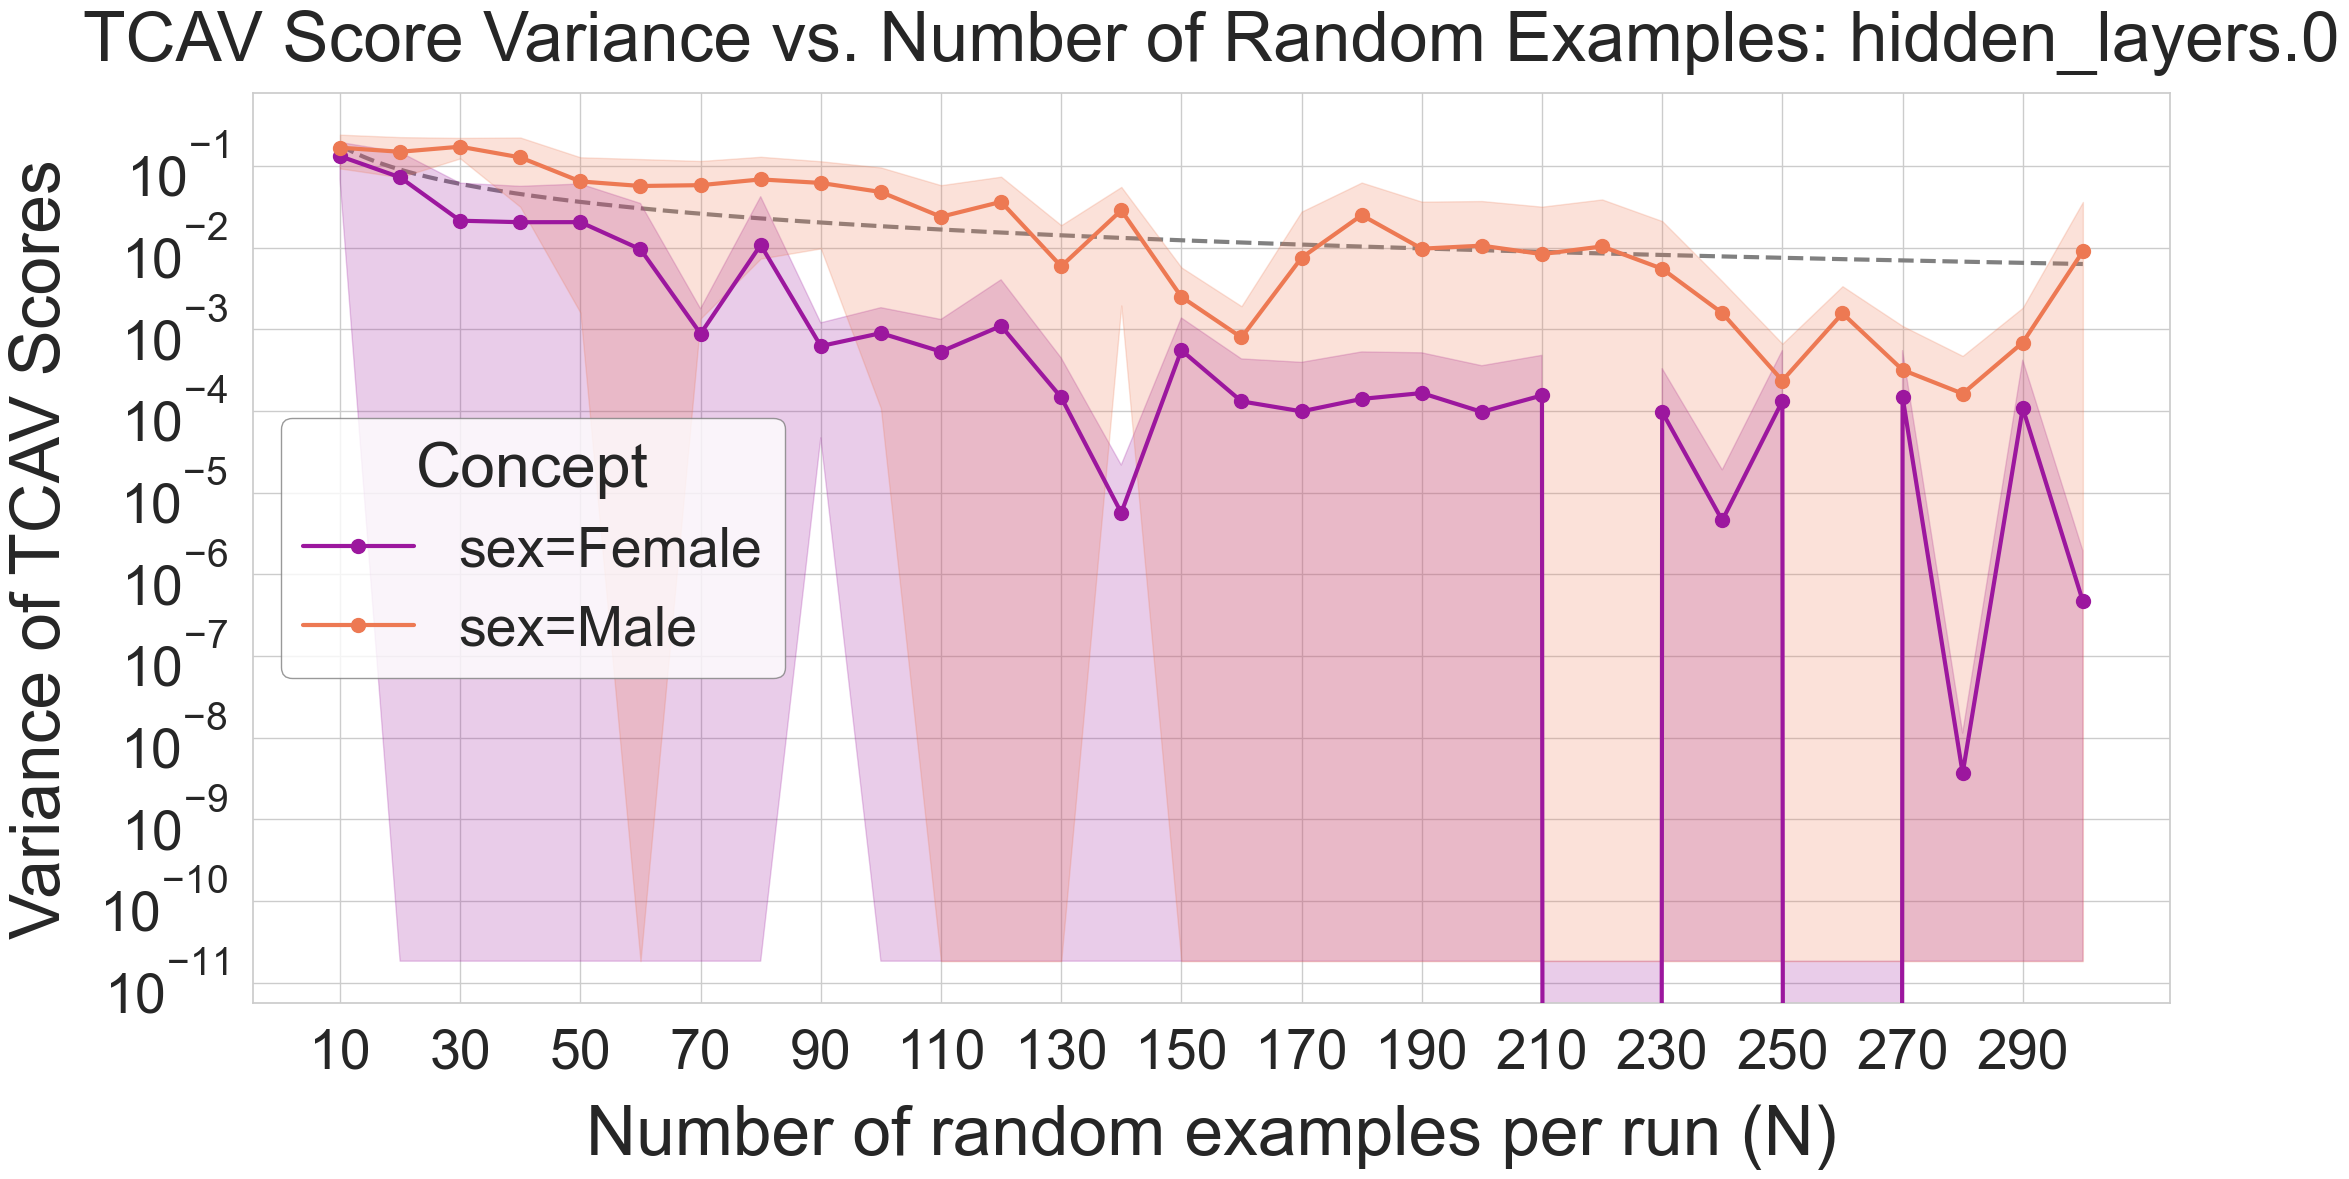

Fit: $ 1.75/N \; + \; 3.04\times 10^{-8} $
Plot saved to artifacts/tabular/mlp_medium/dom/plots/tcav_score_variance_mlp_medium_hidden_layers.2_dom.pdf


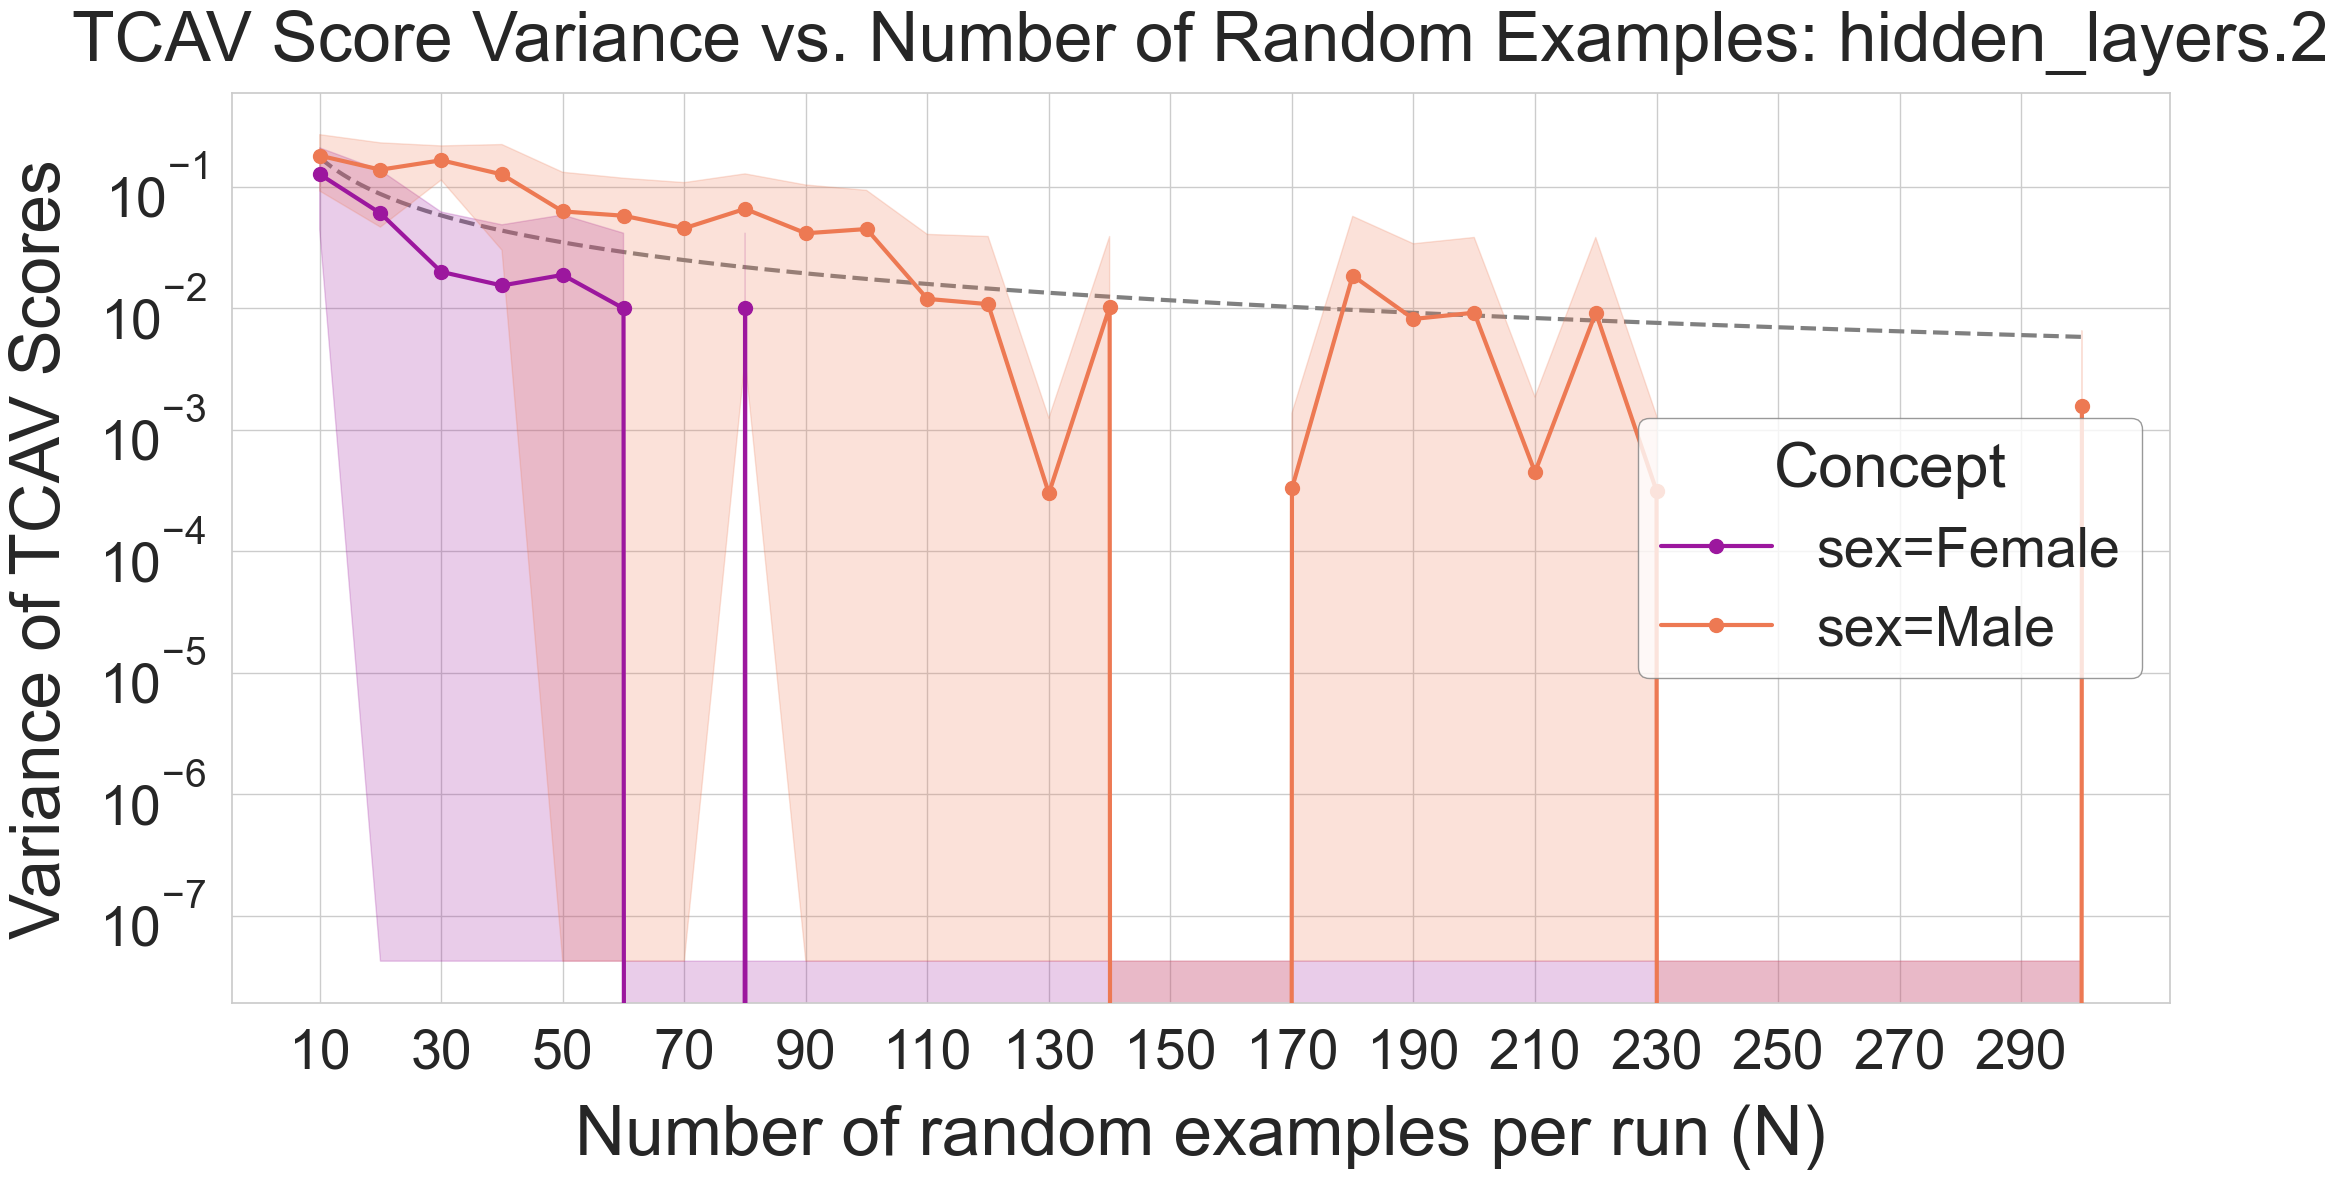

Done.


In [11]:
# 9) TCAV score variance
tensors = [ torch.from_numpy(Xclass[i:i+1]).squeeze(0).to(DEVICE) for i in range(len(Xclass)) ]
grads_by_layer = precompute_gradients_for_class(model, tensors, layer_names, cfg.dataset.target_class_index, DEVICE)
for layer in layer_names:
    if layer not in grads_by_layer: print("Skip TCAV score var for", layer); continue
    df_tcav = calculate_tcav_score_variance_cached(
        layers=[layer], concepts_to_load=cfg.dataset.concepts, n_values=list(cfg.n_values), runs=int(cfg.runs),
        gradients_per_layer=grads_by_layer, cav_output_dir=cfg.out_dir,
        cache_dir=CACHE_DIR, cache_key=f"tcav_score_var__{cfg.dataset.name}_{cfg.method}_{layer}",
        load_if_exists=LOAD_IF_EXISTS, save=True,
    )
    df_layer = df_tcav[df_tcav["layer"]==layer].copy()
    plot_tcav_score_variance(
        df=df_layer, layer_name=layer, palette="plasma",
        save_path=os.path.join(cfg.out_dir, "plots", f"tcav_score_variance_{MODEL}_{layer}_{METHOD}.pdf"),
        cache_dir=CACHE_DIR, cache_key=f"tcav_score_var_plot__{cfg.dataset.name}_{cfg.method}_{layer}",
        load_if_exists=LOAD_IF_EXISTS, save_bundle=True,
    )
print("Done.")


## Checking Assumptions

### Surround Assumption

Layer: fc_in — Concept: sex=Female
Assumption HOLDS for 'male' concept. Plotting distribution...


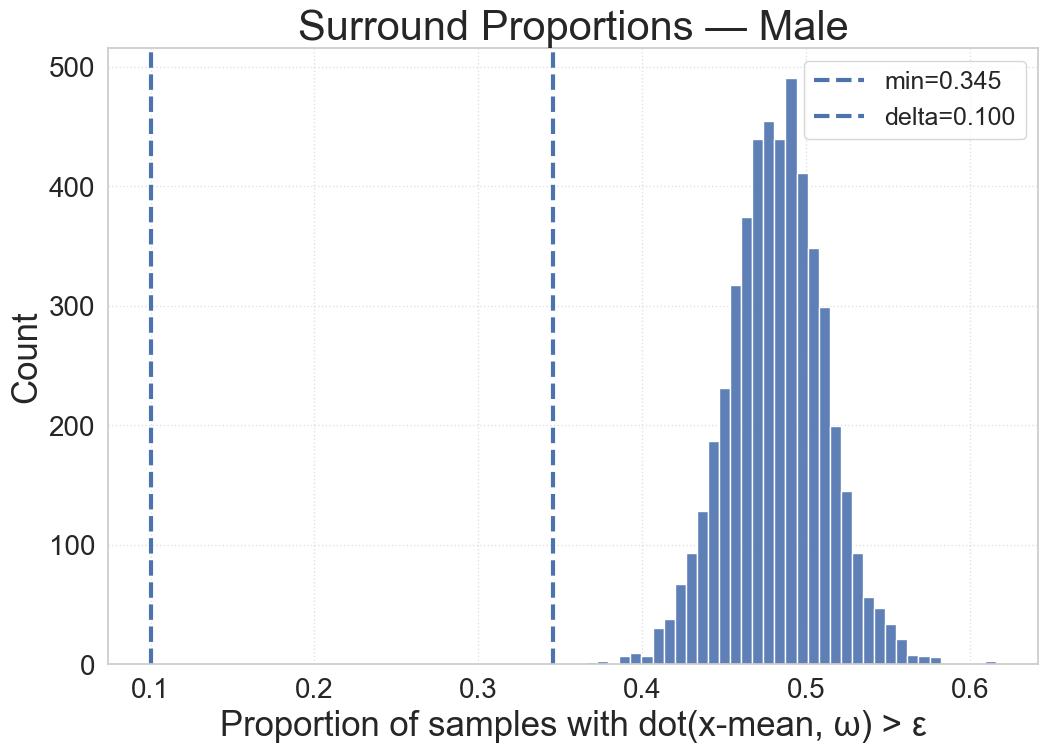

Generating PCA projection plot with larger fonts...


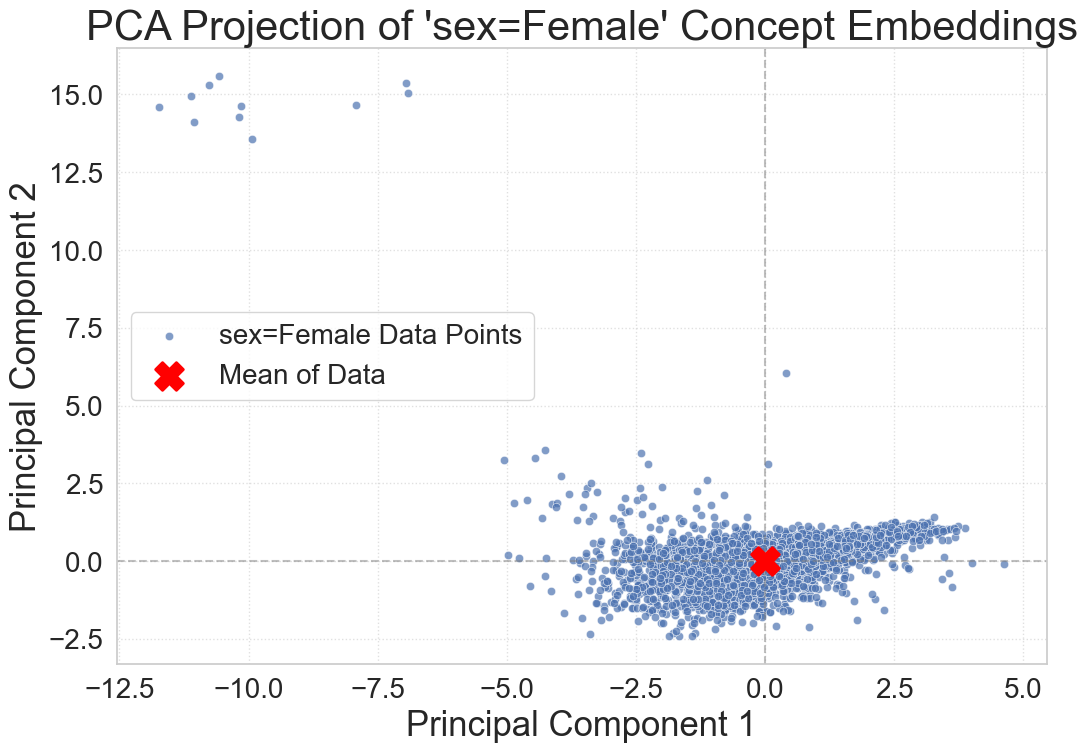

Layer: fc_in — Concept: sex=Male
Assumption HOLDS for 'male' concept. Plotting distribution...


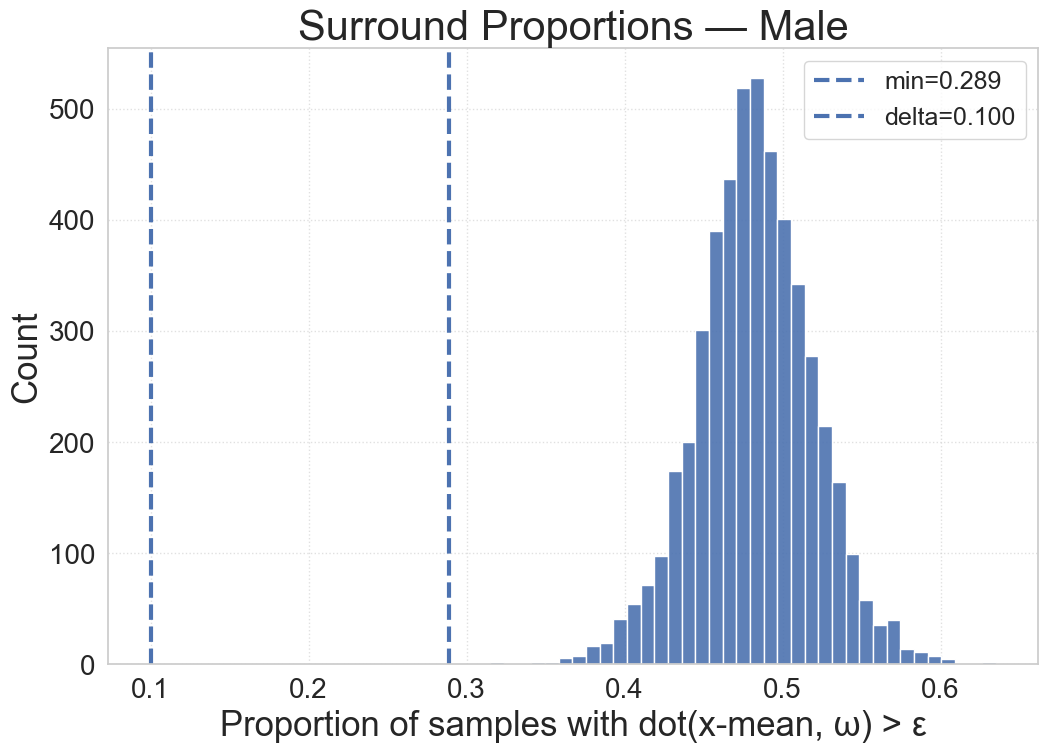

Generating PCA projection plot with larger fonts...


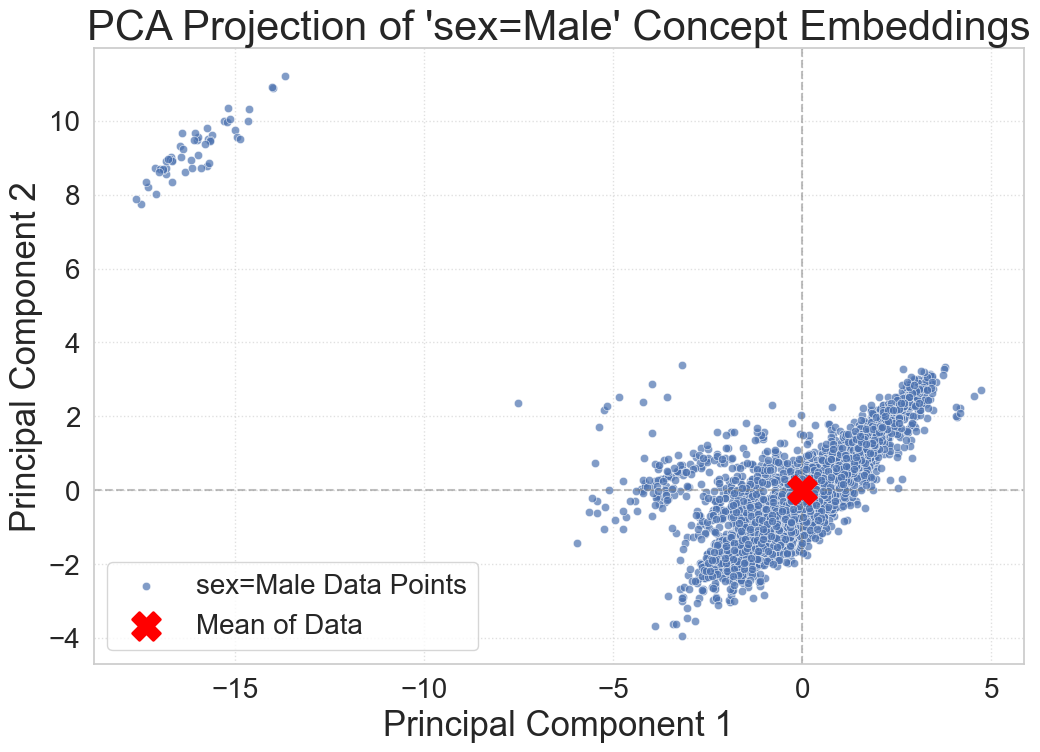

Layer: hidden_layers.0 — Concept: sex=Female
Assumption HOLDS for 'male' concept. Plotting distribution...


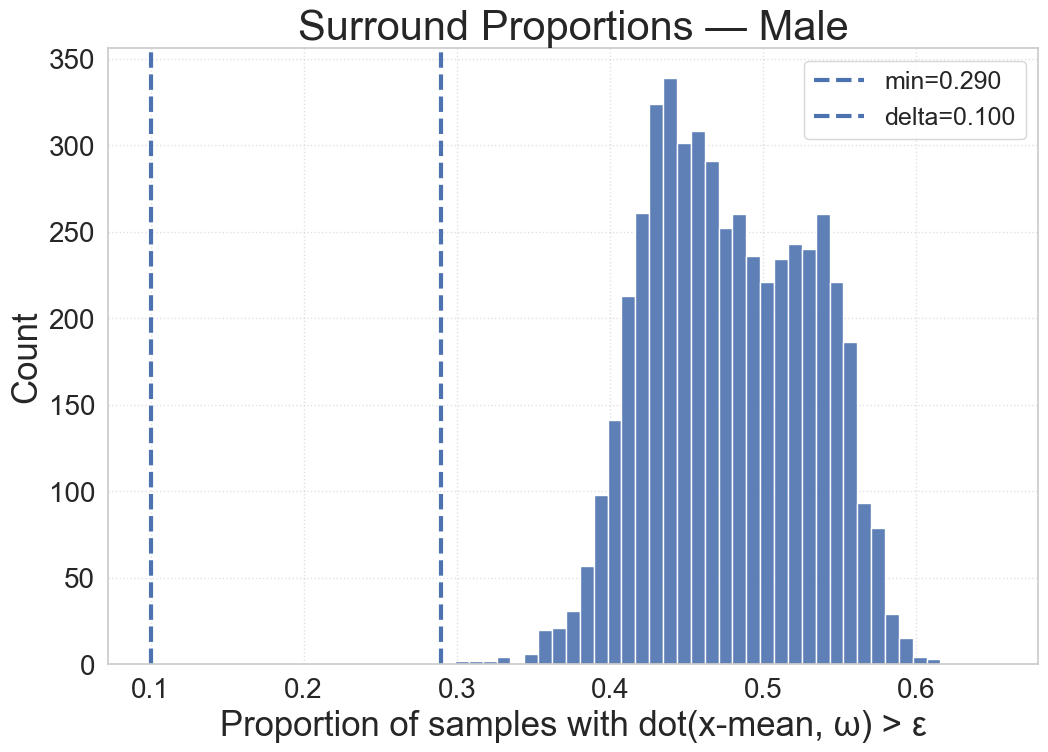

Generating PCA projection plot with larger fonts...


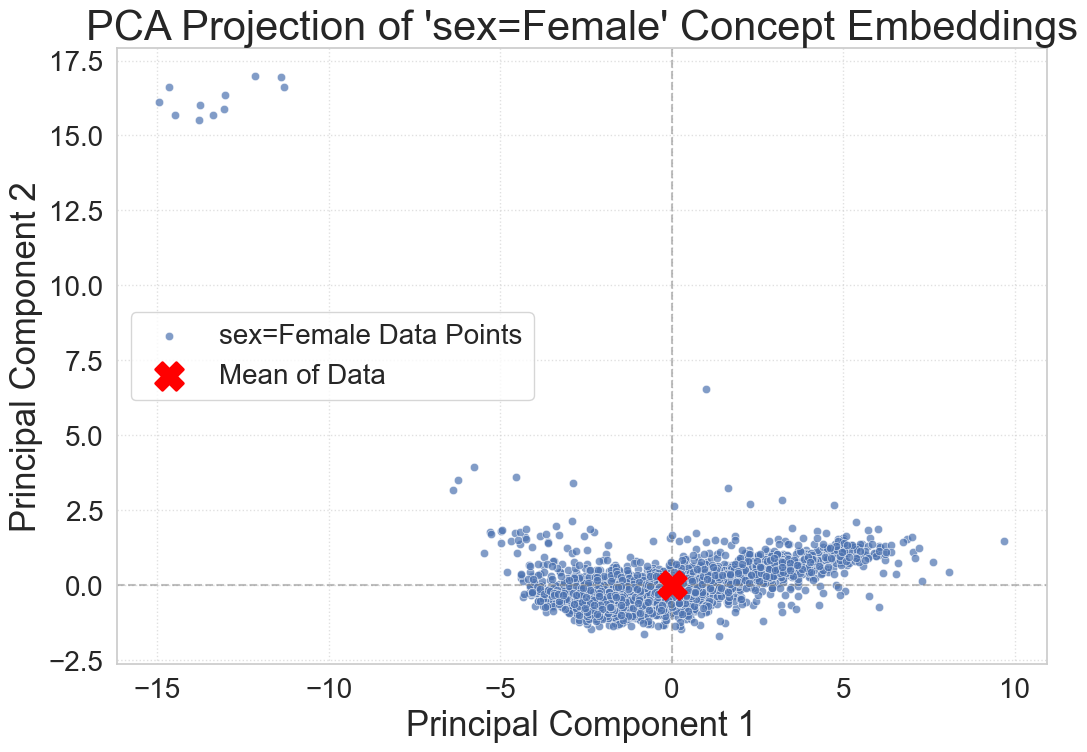

Layer: hidden_layers.0 — Concept: sex=Male
Assumption HOLDS for 'male' concept. Plotting distribution...


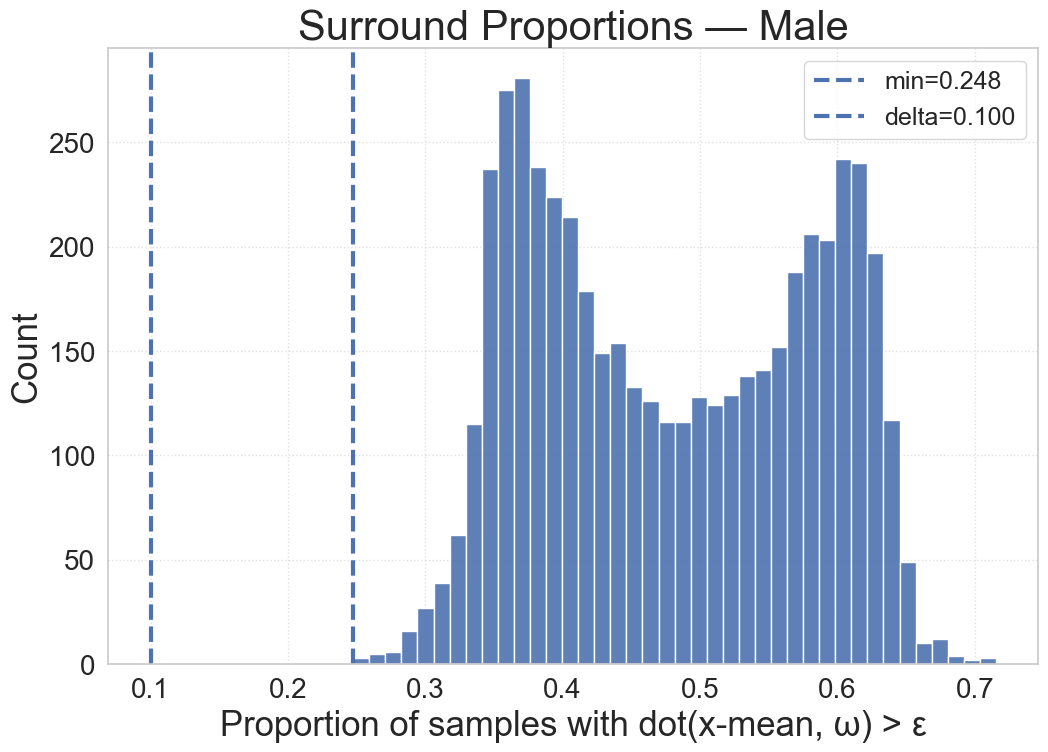

Generating PCA projection plot with larger fonts...


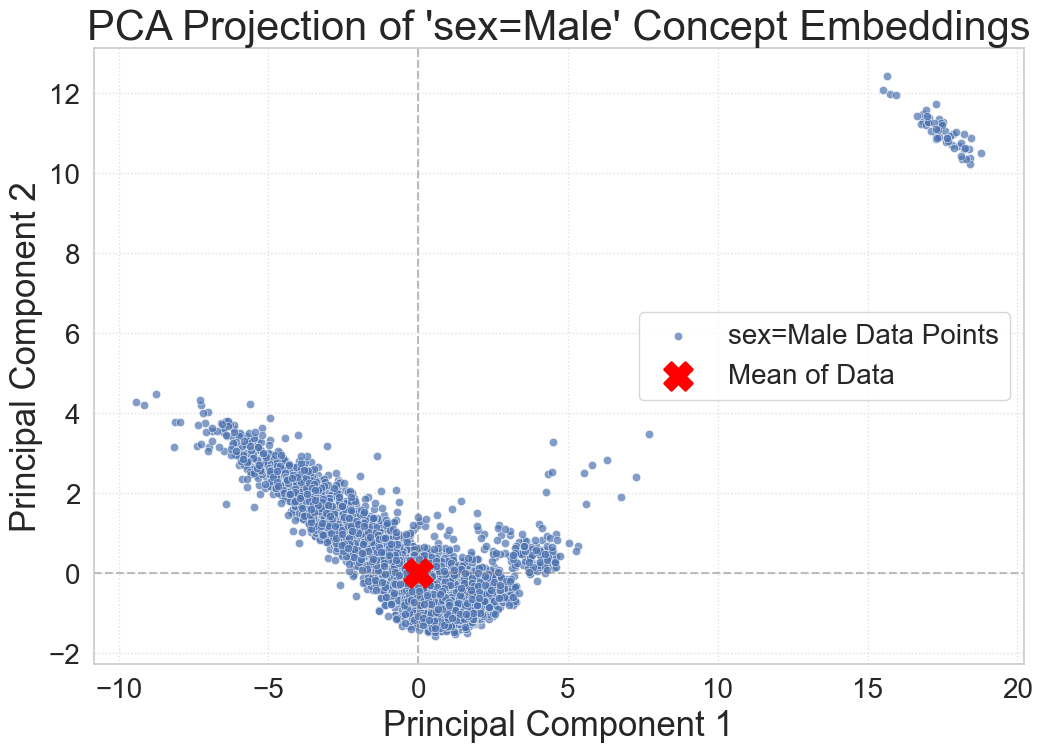

Layer: hidden_layers.2 — Concept: sex=Female
Assumption HOLDS for 'male' concept. Plotting distribution...


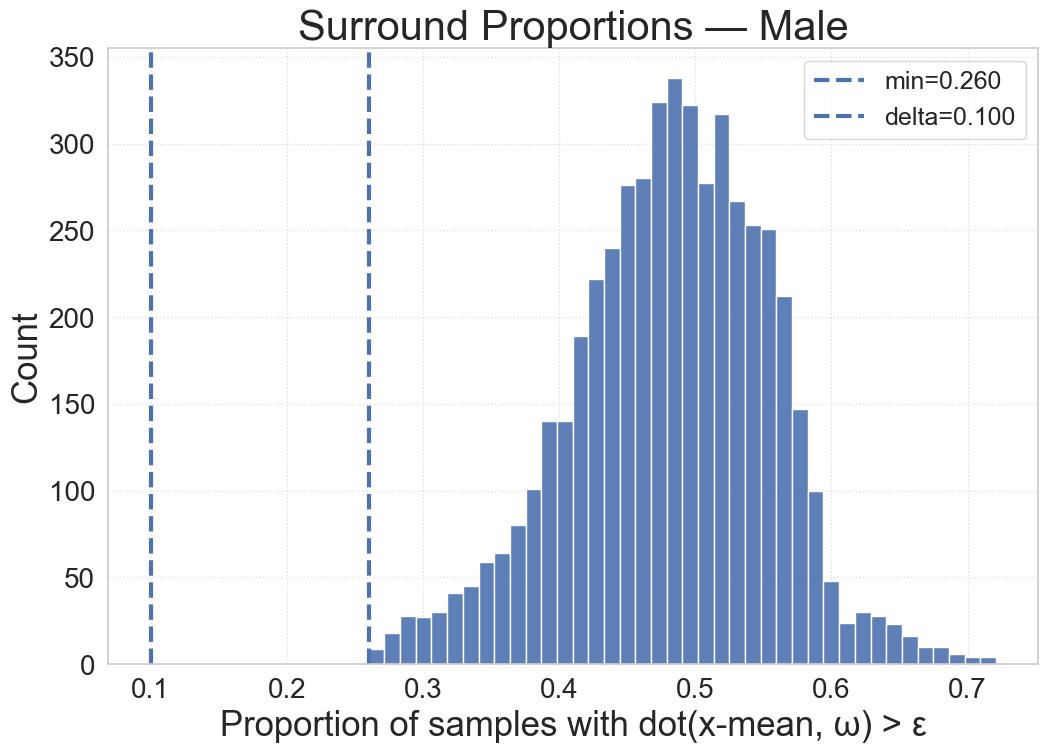

Generating PCA projection plot with larger fonts...


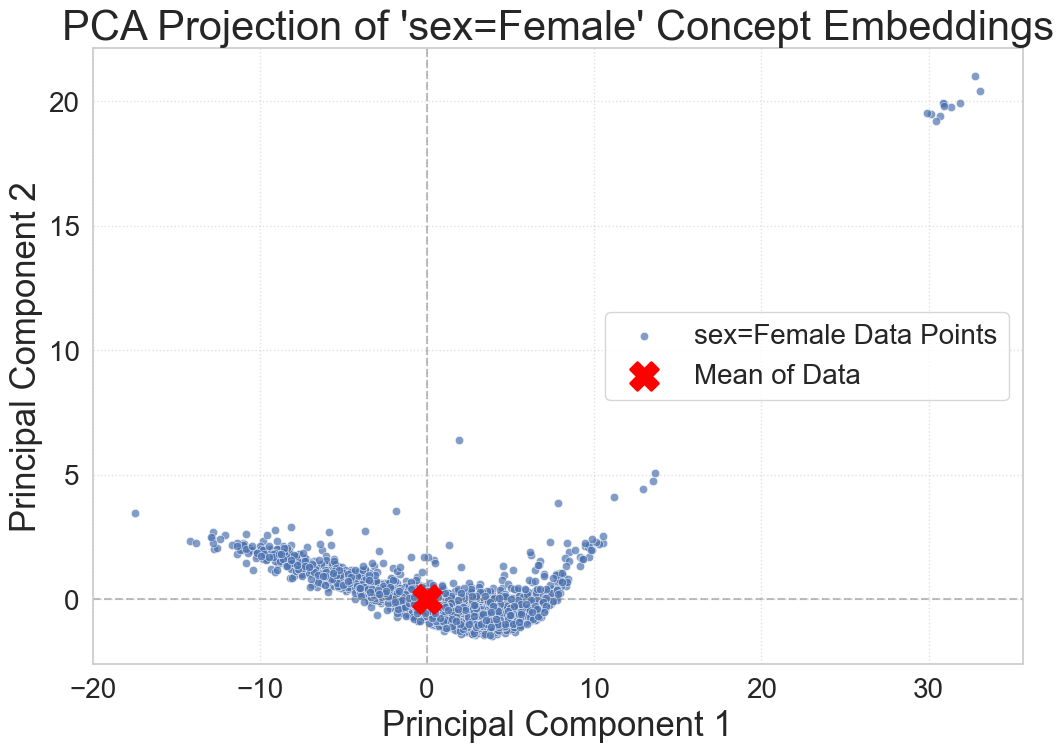

Layer: hidden_layers.2 — Concept: sex=Male
Assumption HOLDS for 'male' concept. Plotting distribution...


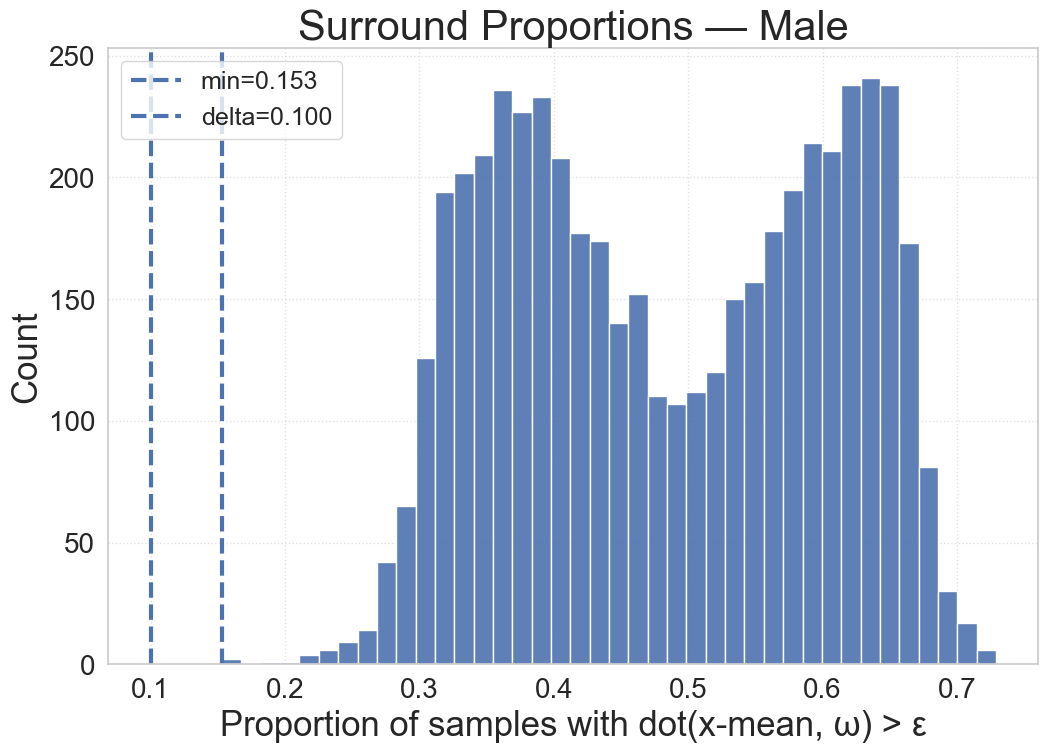

Generating PCA projection plot with larger fonts...


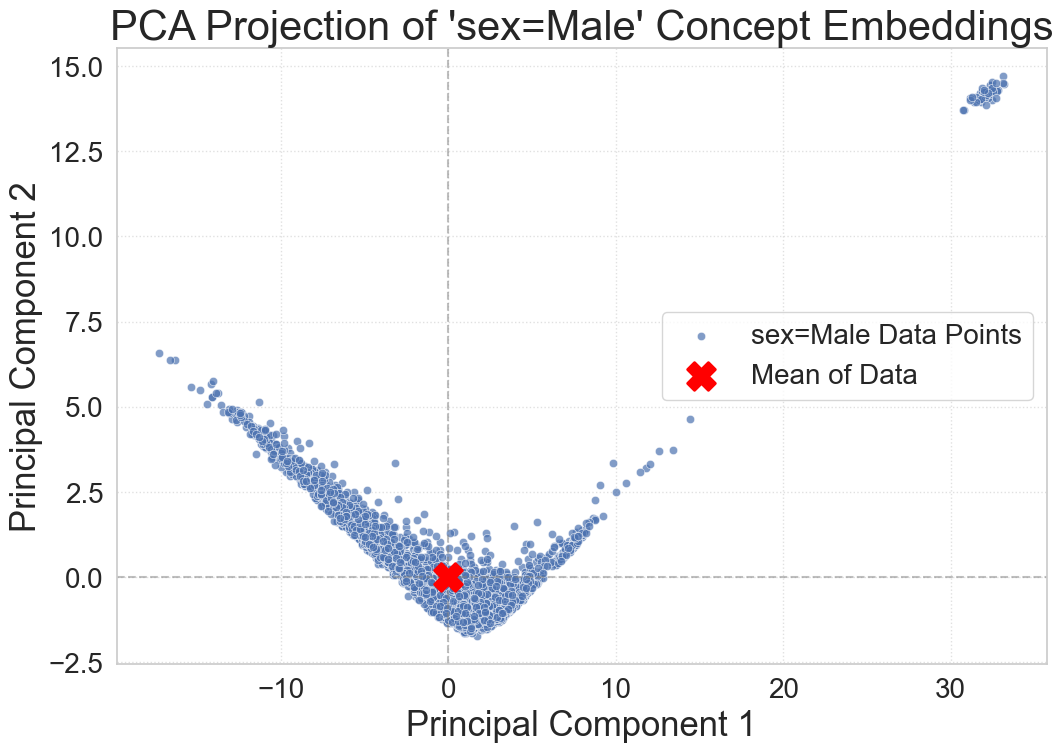

In [12]:
omegas_per_layer = {}

epsilon = 0.01
delta = 0.10

for layer in layer_names:
    for concept in cfg.dataset.concepts:
        print(f"Layer: {layer} — Concept: {concept}")
        pos_acts = activations_from_array(concept_arrays[concept], layer)  # (n, d) for {x_i}
        neg_acts = activations_from_array(Xrand, layer)                    # (N, d) for {z_j} ~ F0
        concept_holds, concept_min_prop, concept_proportions = check_surround_assumption(
            pos_acts, epsilon=epsilon, delta=delta
        )
        if concept_holds:
            print(f"Assumption HOLDS for 'male' concept. Plotting distribution...")
            plot_surround_assumption(concept_proportions, concept_min_prop, delta, 'Male')
        else:
            print(f"Assumption FAILS for 'male' concept.")

        print("Generating PCA projection plot with larger fonts...")
        plot_pca_projection(pos_acts, concept)